# Fantasy Football Draft Analysis

Author: Melody Bass

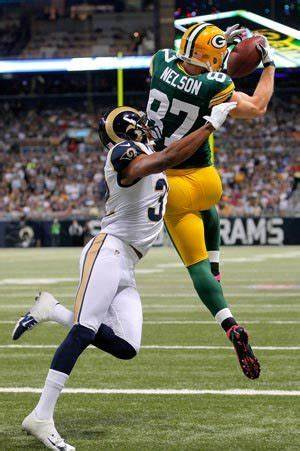

## Overview

## Business Problem

## Data Understanding

In [105]:
# Basics
import pandas as pd
import numpy as np
import itertools

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.pylab import rcParams
import time

# Modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from sklearn.linear_model import LassoLarsCV

# Warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings('ignore')

In [2]:
# load in player fantasy stats data as player_df
player_df = pd.read_csv('data/league_data/player_data/Yahoo-406.l.12345-Players.csv')
player_df.head()

ID  OR Last Name First Name Team     Status Status Details  \
0  406.p.30977   1     Allen       Josh  Buf  Available            NaN   
1  406.p.32676   2   Herbert     Justin  LAC  Available            NaN   
2   406.p.5228   3     Brady        Tom   TB  Available            NaN   
3  406.p.30123   4   Mahomes    Patrick   KC  Available            NaN   
4  406.p.30182   5      Kupp     Cooper  LAR  Available            NaN   

  Eligible Positions  Avg. Pick  Avg. Round  ... Ret TD (DT) XPR (DT)  \
0                 QB       29.7         3.6  ...         NaN      NaN   
1                 QB       61.1         6.8  ...         NaN      NaN   
2                 QB       63.5         7.0  ...         NaN      NaN   
3                 QB       16.6         2.2  ...         NaN      NaN   
4                 WR       42.0         4.8  ...         NaN      NaN   

   Pts Allow 0 (DT)  Pts Allow 1-6 (DT)  Pts Allow 7-13 (DT)  \
0               NaN                 NaN                  NaN   
1               NaN                 NaN                  NaN   
2               NaN                 NaN                  NaN   
3               NaN                 NaN                  NaN   
4               NaN                 NaN                  NaN   

   Pts Allow 14-20 (DT)  Pts Allow 21-27 (DT)  Pts Allow 28-34 (DT)  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   

   Pts Allow 35+ (DT)                                              Image  
0                 NaN  https://s.yimg.com/iu/api/res/1.2/JqjwXUxHWb2L...  
1                 NaN  https://s.yimg.com/iu/api/res/1.2/j0W7BC4RRiJB...  
2                 NaN  https://s.yimg.com/iu/api/res/1.2/Z71ic_5aqQfG...  
3                 NaN  https://s.yimg.com/iu/api/res/1.2/oMIJokh4hdPk...  
4                 NaN  https://s.yimg.com/iu/api/res/1.2/hYxm3SR9yMjD...  

[5 rows x 49 columns]

In [76]:
# load in player fantasy points time series
wr_ts = pd.read_csv('data/wr_ts.csv')
wr_ts['Date'] = pd.to_datetime(wr_ts['Unnamed: 0'])
wr_ts = wr_ts.set_index('Date').drop('Unnamed: 0', axis=1)

qb_ts = pd.read_csv('data/qb_ts.csv')
qb_ts['Date'] = pd.to_datetime(qb_ts['Unnamed: 0'])
qb_ts = qb_ts.set_index('Date').drop('Unnamed: 0', axis=1)

rb_ts = pd.read_csv('data/rb_ts.csv')
rb_ts['Date'] = pd.to_datetime(rb_ts['Unnamed: 0'])
rb_ts = rb_ts.set_index('Date').drop('Unnamed: 0', axis=1)

te_ts = pd.read_csv('data/te_ts.csv')
te_ts['Date'] = pd.to_datetime(te_ts['Unnamed: 0'])
te_ts = te_ts.set_index('Date').drop('Unnamed: 0', axis=1)
qb_ts.head()

Aaron Rodgers (GB)  Baker Mayfield (CAR)  Dak Prescott (DAL)  \
Date                                                                       
2017-09-07                16.5                   NaN                17.1   
2017-09-14                18.5                   NaN                15.9   
2017-09-21                24.8                   NaN                22.9   
2017-09-28                23.1                   NaN                22.6   
2017-10-05                24.0                   NaN                29.7   

            Derek Carr (LV)  Deshaun Watson (CLE)  Jalen Hurts (PHI)  \
Date                                                                   
2017-09-07             18.7                   5.7                NaN   
2017-09-14             21.2                  17.7                NaN   
2017-09-21              5.2                  20.1                NaN   
2017-09-28              9.7                  33.7                NaN   
2017-10-05              NaN                  35.5                NaN   

            Jameis Winston (NO)  Joe Burrow (CIN)  Josh Allen (BUF)  \
Date                                                                  
2017-09-07                  NaN               NaN               NaN   
2017-09-14                 12.5               NaN               NaN   
2017-09-21                 15.5               NaN               NaN   
2017-09-28                 26.5               NaN               NaN   
2017-10-05                 18.5               NaN               NaN   

            Justin Fields (CHI)  ...  Mac Jones (NE)  Matt Ryan (IND)  \
Date                             ...                                    
2017-09-07                  NaN  ...             NaN             17.9   
2017-09-14                  NaN  ...             NaN             14.9   
2017-09-21                  NaN  ...             NaN             13.7   
2017-09-28                  NaN  ...             NaN              8.5   
2017-10-05                  NaN  ...             NaN              NaN   

            Matthew Stafford (LAR)  Patrick Mahomes II (KC)  \
Date                                                          
2017-09-07                    27.1                      NaN   
2017-09-14                    13.2                      NaN   
2017-09-21                    16.5                      NaN   
2017-09-28                    10.1                      NaN   
2017-10-05                    15.2                      NaN   

            Russell Wilson (DEN)  Ryan Tannehill (TEN)  Tom Brady (TB)  \
Date                                                                     
2017-09-07                   8.3                   NaN            10.7   
2017-09-14                  15.3                   NaN            30.8   
2017-09-21                  33.5                   NaN            35.7   
2017-09-28                  27.6                   NaN            20.5   
2017-10-05                  11.5                   NaN            12.6   

            Trevor Lawrence (JAC)  Trey Lance (SF)  Tua Tagovailoa (MIA)  
Date                                                                      
2017-09-07                    NaN              NaN                   NaN  
2017-09-14                    NaN              NaN                   NaN  
2017-09-21                    NaN              NaN                   NaN  
2017-09-28                    NaN              NaN                   NaN  
2017-10-05                    NaN              NaN                   NaN  

[5 rows x 24 columns]

Our filtered dataset contains a wide range of median home values, from a starting range of 53k to 427k for 105 zip codes in the SA metro area with several null values.  The null values are mostly contained in the early years of the data, but due to the massive growth of the area, there is data in the later years of the dataset.

## EDA

### Number of Zip Codes per City in SA Metro

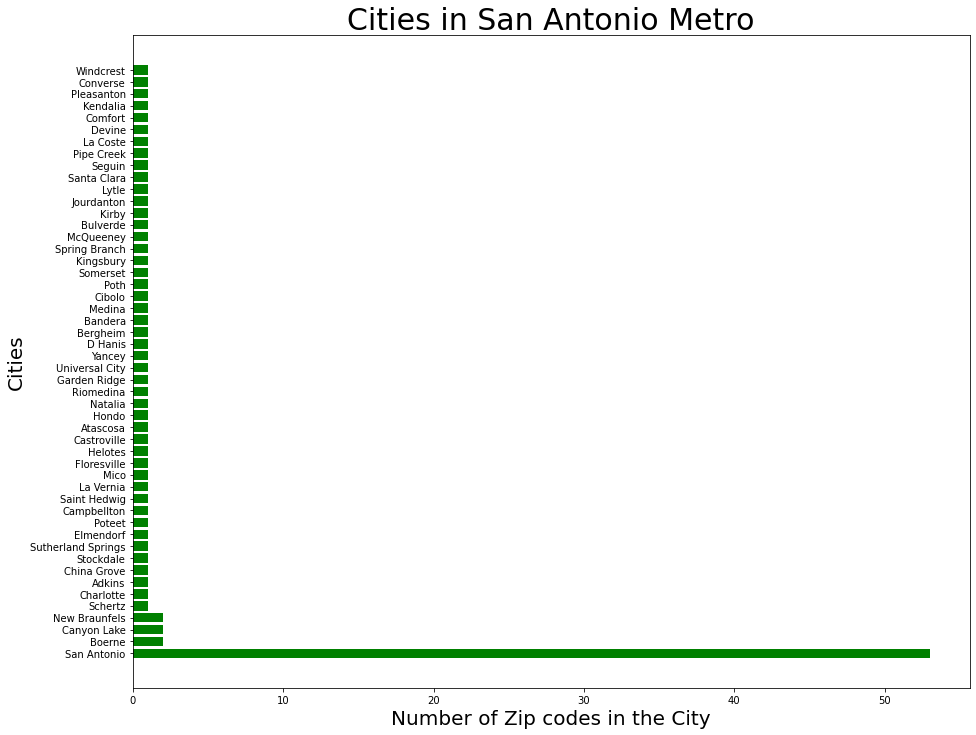

In [8]:
#Visualizing the value counts of zipcodes in each city in the San Antonio metro area

fig, ax = plt.subplots(figsize=(15,12))

y = [a for a in sa_df['City'].value_counts()]

x = [a for a in sa_df['City'].value_counts().keys()]

ax.barh(x,y,color='green')
ax.set_title('Cities in San Antonio Metro',fontsize=30)
ax.set_ylabel('Cities',fontsize=20)
ax.set_xlabel('Number of Zip codes in the City',fontsize=20)
fig.savefig('./images/zip_per_city.jpeg');

There are several small cities in the SA metro area that only have 1 zip code, while San Antonio itself contains 55 zip codes.

### Reshape from Wide to Long Format

The data needs to be melted from wide to long format in order to proceed with visualization and modeling.  Let's go ahead and do that now!

In [9]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], format = '%Y-%m')
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [10]:
# Get average of San Antonio metro zipcodes
satx_df_melted = melt_data(sa_df)
satx_df_melted.tail()

value
time                     
2022-02-28  326126.866667
2022-03-31  331758.419048
2022-04-30  337743.838095
2022-05-31  343256.361905
2022-06-30  347860.333333

In [11]:
# Get average of all US zipcodes
df_melted = melt_data(df)
df_melted.head()

value
time                     
2000-01-31  160670.656547
2000-02-29  161164.847325
2000-03-31  161690.402760
2000-04-30  162842.504295
2000-05-31  164204.550578

### San Antonio vs US Median Home Prices

In order to compare how San Antonio home prices stack up the the US Median home price, I created a time series for the average median prices of the San Antonio area and a time series for the average median price of the US.  Plotted together, we can see the differences.

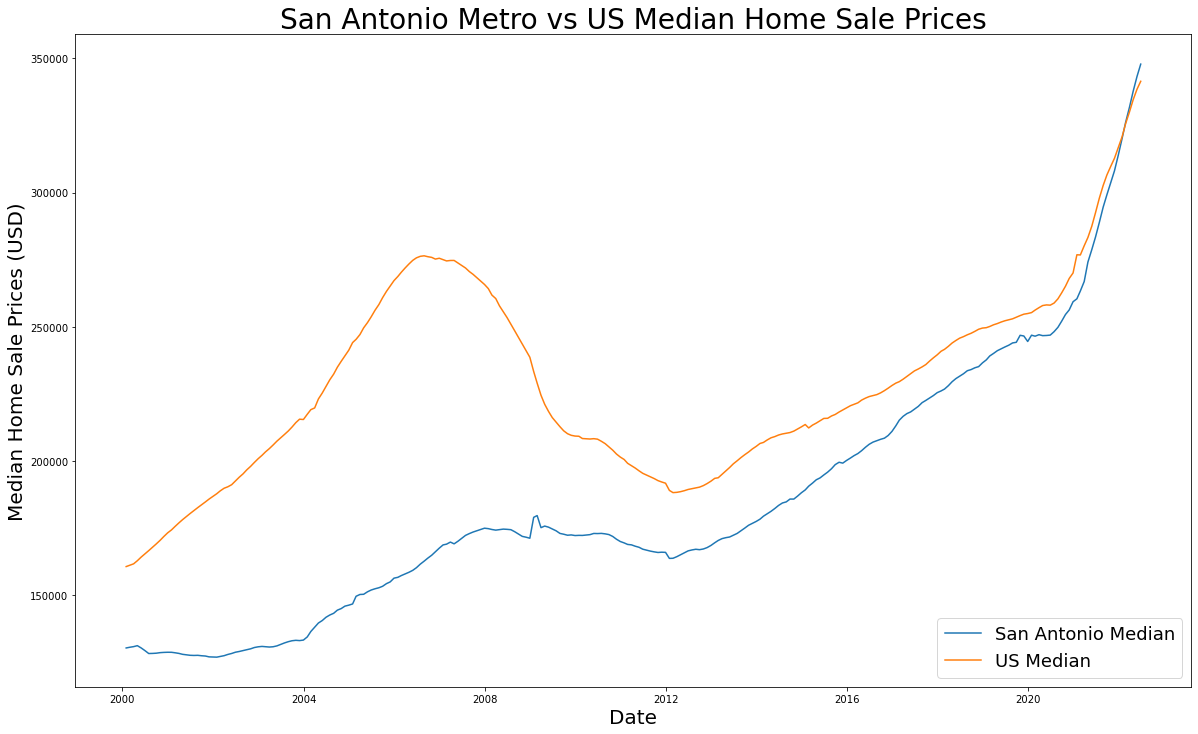

In [12]:
# Plot home value time series for all zip codes averaged

# Define figure
ax = plt.figure(figsize=(20,12))

# Plot
plt.plot(satx_df_melted, label = 'San Antonio Median')
plt.plot(df_melted, label = 'US Median')

# Title, x & y labels
plt.title('San Antonio Metro vs US Median Home Sale Prices', fontsize=28)
plt.ylabel('Median Home Sale Prices (USD)', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.legend(loc='lower right', fontsize=18)
plt.savefig('./images/sa_vs_us.jpeg')

plt.show()

The median home value in San Antonio metro used to be much lower than the national average, but has actually surpassed it this year!  This is due to the massive growth in the area and the low inventory of homes that are available for sale.  We can also see that the housing market in San Antonio was not as affected by the crash in 2008.  I will leave all of the data in the model to provide my client with a more conservative model to forecast housing prices.

Next, I will create another time series that will contain all the location info in long format.

In [13]:
#Create dataframe for new melted data
def melt_df(df):
    merged = []
    for zipcode in df.RegionName:
        melted = melt_data(df.loc[df['RegionName'] == zipcode])
        row = df.loc[df['RegionName'] == zipcode].iloc[:,:6]
        rows = pd.concat([row]*len(melted), ignore_index=True)
        merge = pd.concat([rows, melted.reset_index()], axis= 1)
        merged.append(merge)
    melted_df = pd.concat(merged)
    return melted_df

In [14]:
satx_df = melt_df(sa_df)
satx_df.head()

RegionID  SizeRank  RegionName State           City  \
0     92271        23       78130    TX  New Braunfels   
1     92271        23       78130    TX  New Braunfels   
2     92271        23       78130    TX  New Braunfels   
3     92271        23       78130    TX  New Braunfels   
4     92271        23       78130    TX  New Braunfels   

                       Metro       time     value  
0  San Antonio-New Braunfels 2007-01-31  167985.0  
1  San Antonio-New Braunfels 2007-02-28  168585.0  
2  San Antonio-New Braunfels 2007-03-31  169390.0  
3  San Antonio-New Braunfels 2007-04-30  170118.0  
4  San Antonio-New Braunfels 2007-05-31  170191.0

In [15]:
# Drop columns no longer needed
model_df = satx_df.drop(['RegionID','City','State','Metro','SizeRank'], axis ='columns').set_index('time')
model_df.head()

RegionName     value
time                            
2007-01-31       78130  167985.0
2007-02-28       78130  168585.0
2007-03-31       78130  169390.0
2007-04-30       78130  170118.0
2007-05-31       78130  170191.0

In [16]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24245 entries, 2007-01-31 to 2022-06-30
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionName  24245 non-null  int64  
 1   value       24245 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 568.2 KB


### Average Housing Prices In San Antonio Metro Over Time

Let's take a look at the time series plotted for all 105 zip codes.  We will be able to see the overall trend, but will be very dense on the plot.

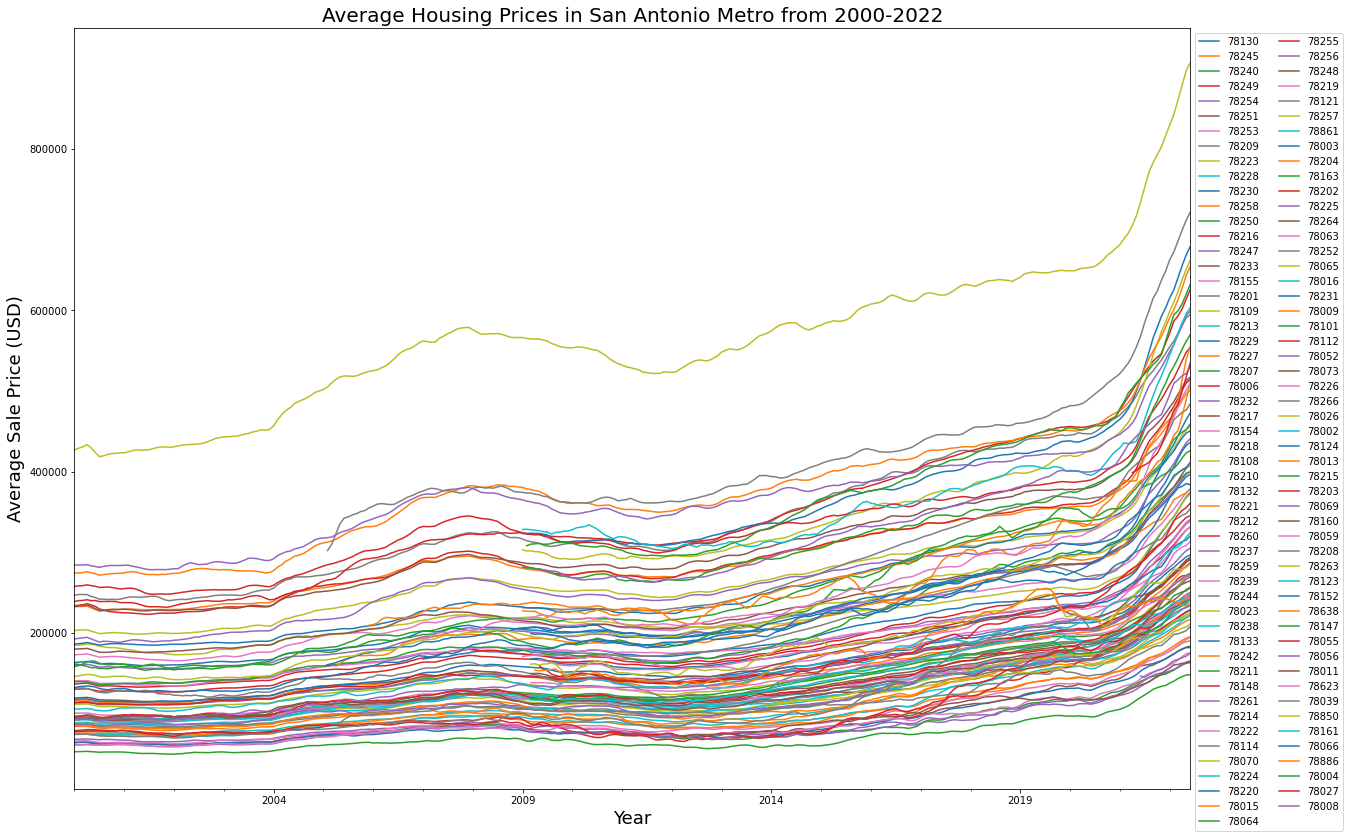

In [17]:
#plot the values grouped by zipcode
plt.figure(figsize=(20,14))
for zipcode in model_df.RegionName.unique():
    model_df.loc[model_df['RegionName'] == zipcode].value.plot(label=zipcode)
plt.legend(bbox_to_anchor=(1,1), loc='upper left', ncol=2)

plt.xlabel("Year", fontsize = 18)
plt.ylabel("Average Sale Price (USD)", fontsize=18)
plt.title('Average Housing Prices in San Antonio Metro from 2000-2022', fontsize = 20)
plt.savefig('./images/all_sa_prices.jpeg')
plt.show();


In [18]:
# Which zipcode is the one with the highest median value?
model_df.loc[model_df['value'] >= 800000]

RegionName     value
time                            
2021-11-30       78257  802164.0
2021-12-31       78257  815748.0
2022-01-31       78257  829571.0
2022-02-28       78257  842365.0
2022-03-31       78257  860608.0
2022-04-30       78257  878970.0
2022-05-31       78257  897059.0
2022-06-30       78257  907023.0

Much to my surprise, 78257 is outside of the main city loop.  These must be a development of custom luxury homes in Leon Springs.

### Zipcodes with Highest 5 Year ROI

In order to narrow down our focus before modeling, we will only keep 10 zip codes with highest ROI based on our last 5 years of historical data.  

In [19]:
# Create copy of df to calculate ROIs
roi_df = sa_df.copy()
roi_df.head()

RegionID  SizeRank  RegionName State           City  \
21      92271        23       78130    TX  New Braunfels   
44      92341        47       78245    TX    San Antonio   
150     92336       153       78240    TX    San Antonio   
378     92345       382       78249    TX    San Antonio   
386     92350       390       78254    TX    San Antonio   

                         Metro    CountyName  2000-01-31  2000-02-29  \
21   San Antonio-New Braunfels  Comal County         NaN         NaN   
44   San Antonio-New Braunfels  Bexar County    116692.0    116770.0   
150  San Antonio-New Braunfels  Bexar County    114140.0    114360.0   
378  San Antonio-New Braunfels  Bexar County    130419.0    130549.0   
386  San Antonio-New Braunfels  Bexar County    140116.0    140318.0   

     2000-03-31  ...  2021-09-30  2021-10-31  2021-11-30  2021-12-31  \
21          NaN  ...    309447.0    316516.0    324563.0    331119.0   
44     116760.0  ...    244895.0    248915.0    252611.0    257498.0   
150    114528.0  ...    253117.0    257176.0    260621.0    265487.0   
378    130699.0  ...    285095.0    289651.0    293690.0    298874.0   
386    140429.0  ...    291980.0    296552.0    300917.0    306526.0   

     2022-01-31  2022-02-28  2022-03-31  2022-04-30  2022-05-31  2022-06-30  
21     338337.0    344167.0    352261.0    360881.0    368831.0    374204.0  
44     262334.0    266894.0    272647.0    278366.0    283640.0    286831.0  
150    269931.0    274313.0    279550.0    285112.0    289780.0    292773.0  
378    304272.0    309388.0    315964.0    322271.0    327902.0    331461.0  
386    312036.0    317171.0    323982.0    330791.0    337059.0    340772.0  

[5 rows x 277 columns]

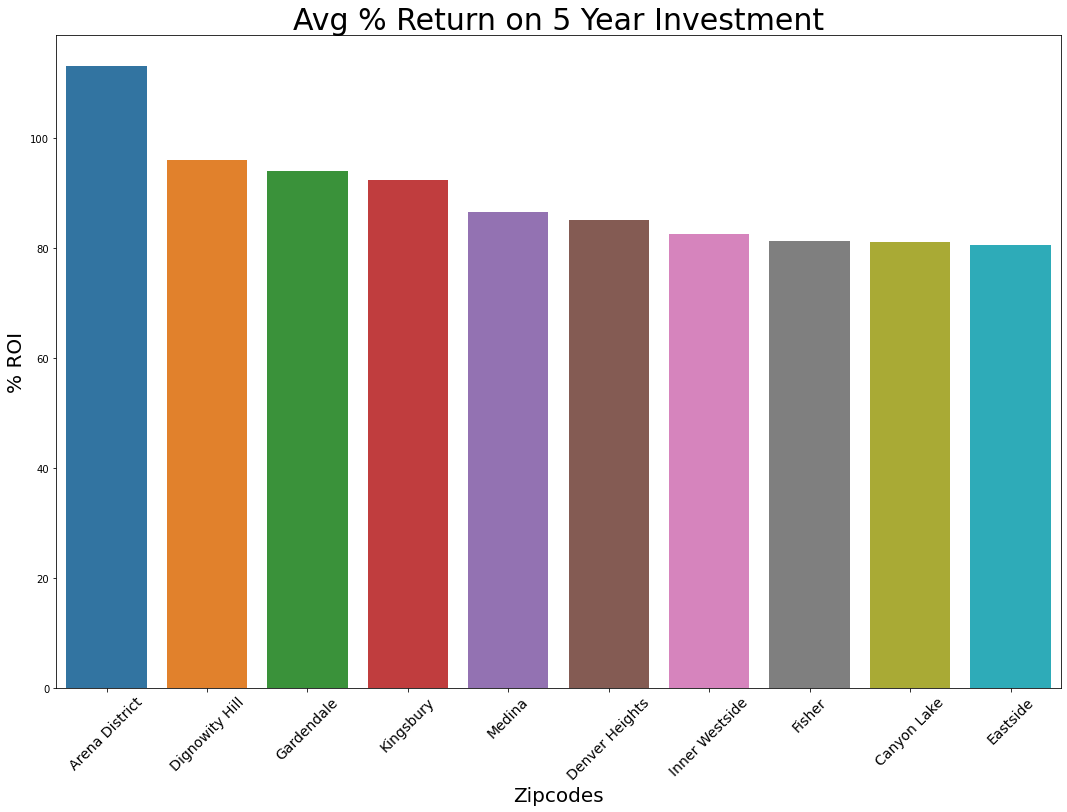

In [20]:
# Calculate 5 year ROI and keep top 10
roi_df['roi_5_year'] = ((roi_df['2022-06-30'] - roi_df['2017-06-30'])/(roi_df['2017-06-30'])*100)
sa_5_year_roi = roi_df.sort_values('roi_5_year',ascending=False).head(10)
sa_5_year_roi['RegionName'] = sa_5_year_roi['RegionName'].astype(str)

#Plot
fig,ax=plt.subplots(figsize=(18,12))
sns.barplot('RegionName', 'roi_5_year', data = sa_5_year_roi)


zip_name_list = ['Arena District', 'Dignowity Hill', 'Gardendale', 'Kingsbury', 'Medina', 'Denver Heights', 
                 'Inner Westside', 'Fisher', 'Canyon Lake', 'Eastside']

#rotate the x-axis text and change to month name 
ax.set_xticklabels(zip_name_list, rotation = 45, size = 14)

# Axis labels and title
ax.set_ylabel('% ROI',fontsize='20')
ax.set_xlabel('Zipcodes',fontsize='20')
ax.set_title('Avg % Return on 5 Year Investment',fontsize='30')

#Save fig
plt.savefig('./images/roi_5_year.jpeg');

78203 contains the Arena District, which is the area surrounding the AT&T Center.  The other zip codes with highest ROI are spread all around the city in every direction. While most are around the downtown area, there are several suburbs like Canyon Lake and Medina that have taken the top ROI spots!

### Zip Codes with Highest 22 Year ROI

Out of curiosity, are the zip codes with the highest ROI over 22 years the same as the top 10 zip codes over the last 5 years?

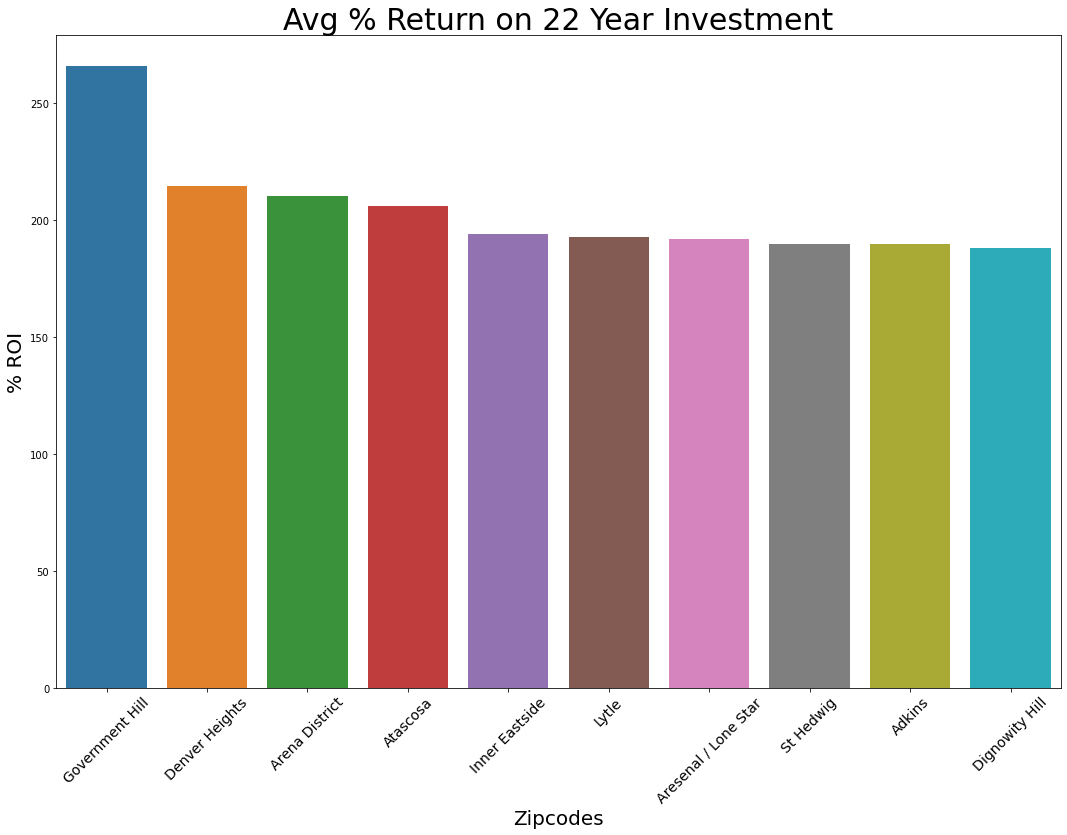

In [21]:
# Calculate 22 year ROI and keep top 10
roi_df['roi_22year'] = ((roi_df['2022-06-30'] - roi_df['2000-01-31'])/(roi_df['2000-01-31'])*100)
sa_22_year_roi = roi_df.sort_values('roi_22year',ascending=False).head(10)
sa_22_year_roi['RegionName'] = sa_22_year_roi['RegionName'].astype(str)

#Plot
fig,ax=plt.subplots(figsize=(18,12))
sns.barplot('RegionName', 'roi_22year', data = sa_22_year_roi)

zip_name_list_22 = ['Government Hill', 'Denver Heights', 'Arena District', 'Atascosa', 'Inner Eastside',
                 'Lytle', 'Aresenal / Lone Star', 'St Hedwig', 'Adkins', 'Dignowity Hill']

#rotate the x-axis text and change to month name 
ax.set_xticklabels(zip_name_list_22, rotation = 45, size = 14)

# Title and Axis Labels
ax.set_ylabel('% ROI',fontsize='20')
ax.set_xlabel('Zipcodes',fontsize='20')
ax.set_title('Avg % Return on 22 Year Investment',fontsize='30');

Only 3 zip codes that have the highest ROI on a 5 year investment are in the highest ROI over a 22 year investment.  This is once again due to new developments in the suburban areas, as well as gentrification of areas that were once undesirable.

### Seasonality EDA

According to the National Association of Realtors, the number of home sales increases significantly in the spring, with home sales increasing by 34% in February and March. Sales continue upward with the busiest home selling months being May through August, accounting for 40% of United States annual home sales volume. The slowest months are November through February. Prices of homes slightly increase during surge months when the demand in the market is higher. Therefore, selling homes during these peak times could prove to be advantageous for maximizing profits.[[4]](https://www.nar.realtor/blogs/economists-outlook/seasonality-in-the-housing-market) 

In order to study the seasonality in our data further and determine the best time of year to buy and sell houses in our top zip codes for maximizing profits, I am going to calculate the average 6 month ROI for winter and summer sales (i.e. a winter sale is a house that was purchased the previous summer and sold in the winter, while a summer sale is a house that was purchased during the winter and sold the next summer). I am going to calculate this over the last 5 years and take the average ROI gains for each time period.  

In [22]:
# Calculate summer sale ROI
sa_5_year_roi['roi_summer_sale_2018'] = ((sa_5_year_roi['2018-07-31'] - sa_5_year_roi['2018-01-31'])/
                                         (sa_5_year_roi['2018-01-31'])*100)
sa_5_year_roi['roi_summer_sale_2019'] = ((sa_5_year_roi['2019-07-31'] - sa_5_year_roi['2019-01-31'])/
                                         (sa_5_year_roi['2019-01-31'])*100)
sa_5_year_roi['roi_summer_sale_2020'] = ((sa_5_year_roi['2020-07-31'] - sa_5_year_roi['2020-01-31'])/
                                         (sa_5_year_roi['2020-01-31'])*100)
sa_5_year_roi['roi_summer_sale_2021'] = ((sa_5_year_roi['2021-07-31'] - sa_5_year_roi['2021-01-31'])/
                                         (sa_5_year_roi['2021-01-31'])*100)
sa_5_year_roi['roi_summer_sale_2022'] = ((sa_5_year_roi['2022-06-30'] - sa_5_year_roi['2022-01-31'])/
                                         (sa_5_year_roi['2022-01-31'])*100)
sa_5_year_roi['average_summer_sale_roi'] = sa_5_year_roi[['roi_summer_sale_2018', 'roi_summer_sale_2019',
                                                          'roi_summer_sale_2020', 'roi_summer_sale_2021',
                                                          'roi_summer_sale_2022']].mean(axis=1).round(2)
#Calculate winter sale ROI
sa_5_year_roi['roi_winter_sale_2018'] = ((sa_5_year_roi['2018-01-31'] - sa_5_year_roi['2017-07-31'])/
                                         (sa_5_year_roi['2017-07-31'])*100)
sa_5_year_roi['roi_winter_sale_2019'] = ((sa_5_year_roi['2019-01-31'] - sa_5_year_roi['2018-07-31'])/
                                         (sa_5_year_roi['2018-07-31'])*100)
sa_5_year_roi['roi_winter_sale_2020'] = ((sa_5_year_roi['2020-01-31'] - sa_5_year_roi['2019-07-31'])/
                                         (sa_5_year_roi['2019-07-31'])*100)
sa_5_year_roi['roi_winter_sale_2021'] = ((sa_5_year_roi['2021-01-31'] - sa_5_year_roi['2020-07-31'])/
                                         (sa_5_year_roi['2020-07-31'])*100)
sa_5_year_roi['roi_winter_sale_2022'] = ((sa_5_year_roi['2022-01-31'] - sa_5_year_roi['2021-07-31'])/
                                         (sa_5_year_roi['2021-07-31'])*100)
sa_5_year_roi['average_winter_sale_roi'] = sa_5_year_roi[['roi_winter_sale_2018', 'roi_winter_sale_2019',
                                                          'roi_winter_sale_2020', 'roi_winter_sale_2021',
                                                          'roi_winter_sale_2022']].mean(axis=1).round(2)

# Sort rows by highest summer sale ROI
sa_summer_roi = sa_5_year_roi.sort_values('average_summer_sale_roi',ascending=False).head(10)

# Make column for neighborhood name
# Top 10 zip code names        
top_zip_names =  ['Gardendale', 'Kingsbury', 'Dignowity Hill', 'Inner Westside', 'Fisher', 
                 'Arena District', 'Canyon Lake', 'Medina', 'Denver Heights', 'Eastside']
sa_summer_roi['Neighborhood'] = top_zip_names

# Keep columns we want
sa_seasonal_roi = sa_summer_roi.reindex(columns=['RegionName', 'Neighborhood', 'average_summer_sale_roi',
                                                 'average_winter_sale_roi'])
sa_seasonal_roi

RegionName    Neighborhood  average_summer_sale_roi  \
1643       78207      Gardendale                     7.61   
17365      78638       Kingsbury                     7.28   
9383       78202  Dignowity Hill                     7.14   
3806       78237  Inner Westside                     7.13   
18678      78623          Fisher                     6.65   
13033      78203  Arena District                     6.34   
4637       78133     Canyon Lake                     6.27   
17996      78055          Medina                     5.95   
2710       78210  Denver Heights                     5.88   
6754       78220        Eastside                     5.70   

       average_winter_sale_roi  
1643                      6.16  
17365                     6.23  
9383                      6.62  
3806                      5.29  
18678                     5.80  
13033                     8.64  
4637                      6.21  
17996                     6.89  
2710                      6.48  
6754                      6.18

For most of our top zip codes, we can see about a 1% average ROI gain if we were to buy in the winter and sell in the summer.  Interestingly enough, 4 of our zip codes show higher ROI gains if we were to buy in the summer and sell in the winter.  The Arena District has over 2% higher ROI for a winter sale as opposed to a summer sale. A winter sale in Medina will increase ROI by 1%, while Denver Heights and the Eastside are about 0.5% increase. 

### Discussion on EDA

There is a similar trend amongst all of our neighborhoods in the SA metro area.  There is also a very wide range of median housing values, where the more affluent neighborhoods have a a much higher value than others.

We can also clearly see the housing bubble and 2008 crash in the data.  Values increased rapidly starting in 2004 and took a dip through 2009, plateaued, and begin rising again in 2012.  All zip codes in the San Antonio metro were mildly affected by this crash in comparison to the rest of the US.  A number of reasons contributed to this crash outside of the typical housing market highs and lows, and while they are rare, they do occur and are unpredictable.  I am going to leave this data in for our model to create a more conservative forecast for my client.

As discussed above, we know that there is going to be seasonality in our data and I will use SARIMAX for my time series model.  

## SARIMAX Modeling

### Create Time Series for Each Zip Code in Our Top 10

Our zip_df now contains a list of 10 time series for each of our 10 zipcodes of interest.

### Seasonal Decomposition

We can also decompose our time series to look for trend and seasonality.  

Let's start by looking at our top ROI zip code - 78203 (Arena District), and 78133 (Canyon Lake), which has had huge ROI gains in the last 2 years compared to all data in the dataset.

In [77]:
def decomposition_plot(ts):
    decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=17)

    #Gather the trend, seasonality, and residuals
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(ts, label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout();
    return decomposition_plot

<function __main__.decomposition_plot(ts)>

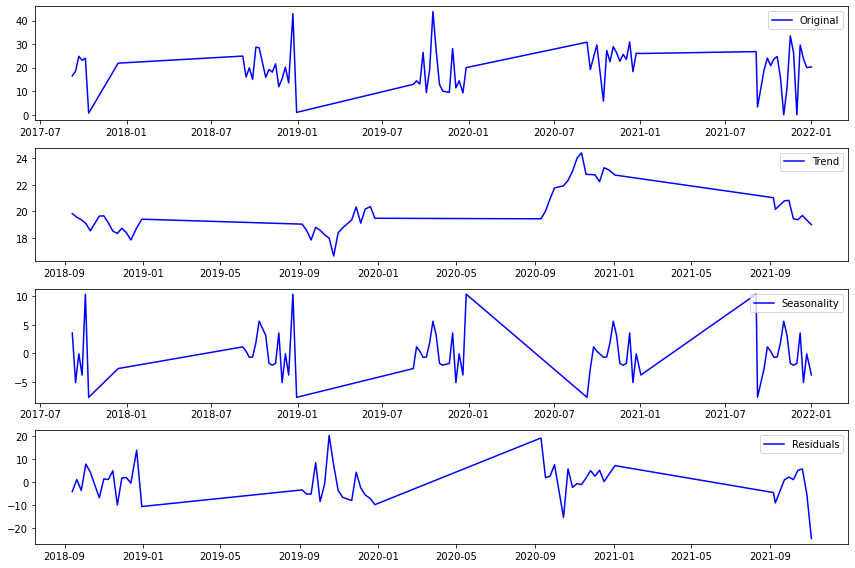

In [106]:
#Decomposition plot of the Arena District
decomposition_plot(qb_ts['Aaron Rodgers (GB)'].dropna())

In [79]:
qb_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85 entries, 2017-09-07 to 2022-01-02
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Aaron Rodgers (GB)       72 non-null     float64
 1   Baker Mayfield (CAR)     63 non-null     float64
 2   Dak Prescott (DAL)       70 non-null     float64
 3   Derek Carr (LV)          80 non-null     float64
 4   Deshaun Watson (CLE)     71 non-null     float64
 5   Jalen Hurts (PHI)        32 non-null     float64
 6   Jameis Winston (NO)      61 non-null     float64
 7   Joe Burrow (CIN)         27 non-null     float64
 8   Josh Allen (BUF)         61 non-null     float64
 9   Justin Fields (CHI)      17 non-null     float64
 10  Justin Herbert (LAC)     32 non-null     float64
 11  Kirk Cousins (MIN)       80 non-null     float64
 12  Kyler Murray (ARI)       49 non-null     float64
 13  Lamar Jackson (BAL)      63 non-null     float64
 14  Mac Jone

<function __main__.decomposition_plot(ts)>

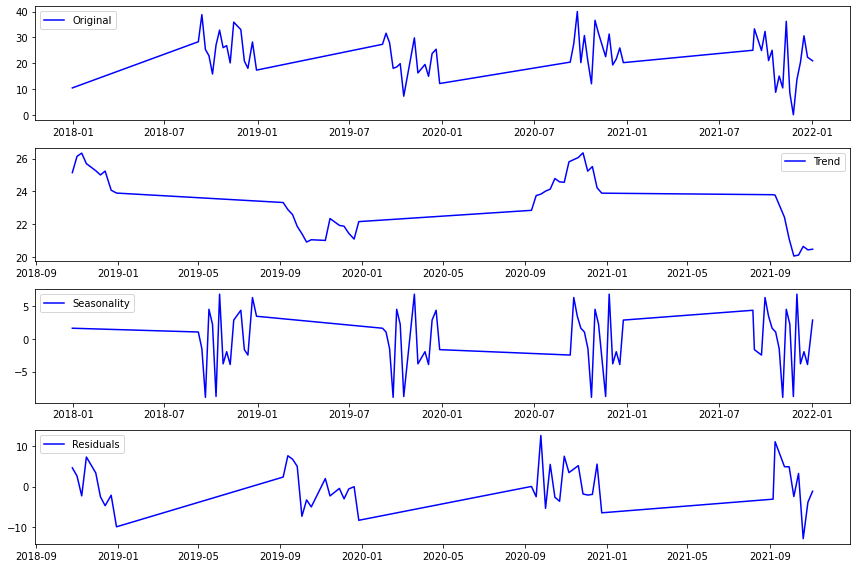

In [80]:
# #Decomposition plot of Canyon Lake
decomposition_plot(qb_ts['Patrick Mahomes II (KC)'].dropna())

We can clearly see the seasonality in the individual zip codes and the SA Median average.  There is also an overall upwards trend after the small dip after the housing bubble popped, with a steep increase over the last 2 years.

### Stationarity Check

In [30]:
def stationarity_check(TS):
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [31]:
# Get decomposition for stationarity check
decomposition = sm.tsa.seasonal_decompose(satx_df_melted, model='additive')
residual = decomposition.resid
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

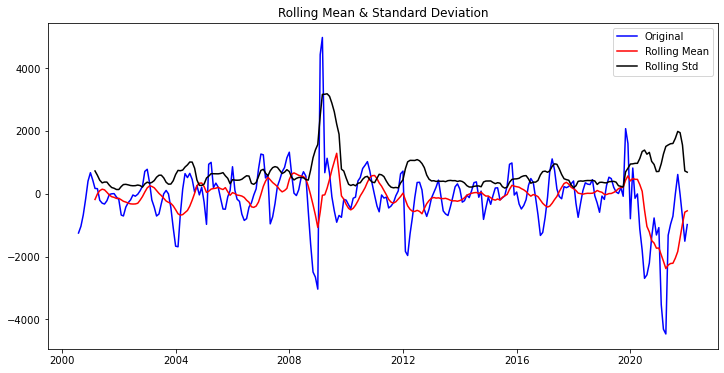

Results of Dickey-Fuller Test: 

Test Statistic                  -4.393976
p-value                          0.000304
#Lags Used                       6.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


In [32]:
stationarity_check(ts_log_decompose)

The p-value is <0.05, which means we accept the null hypothesis that the residuals are stationary. We can move on to check our autocorrelation and partial autocorrelation plots.

### Autocorrelation and Partial Autocorrelation

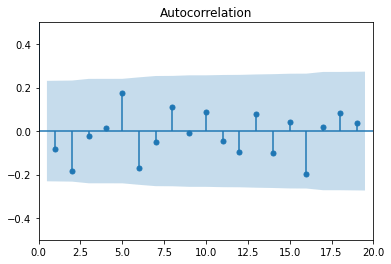

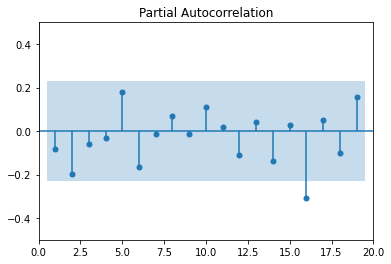

In [81]:
plot_acf(qb_ts['Aaron Rodgers (GB)'].dropna()); plt.xlim(0,20); plt.ylim(-0.5,0.5);plt.show()
plot_pacf(qb_ts['Aaron Rodgers (GB)'].dropna()); plt.xlim(0,20); plt.ylim(-0.5,0.5);plt.show()

There is a slow decline in our autocorrelation plot, while the partial autocorrelation drops off right away.  This means we should use an Autoregressive model for out data, but we are going to run gridsearch anyway to find best parameters.  We can try to plot again with a lag of 3, which would make sense for different seasons of the year.

<AxesSubplot:xlabel='Date'>

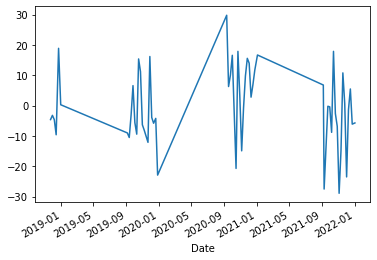

In [107]:
qb_ts['Aaron Rodgers (GB)'].dropna().diff(periods=17).plot()

We can see some autocorrelation at a lag of 3.

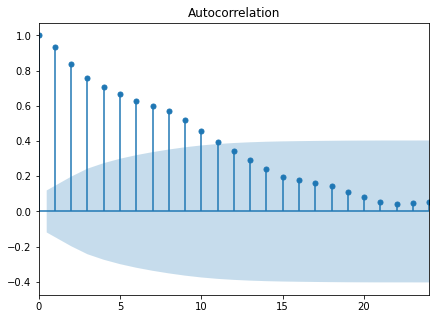

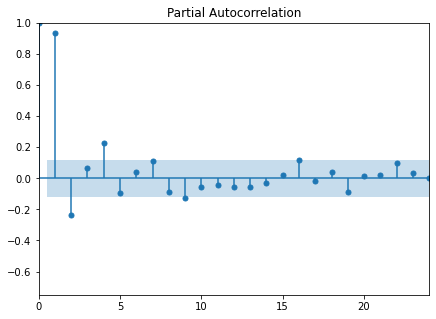

In [35]:
rcParams['figure.figsize']=7,5
plot_acf(satx_df_melted.diff(periods=3).bfill()); plt.xlim(0,24); plt.show()
plot_pacf(satx_df_melted.diff(periods=3).bfill()); plt.xlim(0,24); plt.ylim(-0.75,1);plt.show()

In [36]:
model_df

RegionName     value
time                            
2007-01-31       78130  167985.0
2007-02-28       78130  168585.0
2007-03-31       78130  169390.0
2007-04-30       78130  170118.0
2007-05-31       78130  170191.0
...                ...       ...
2022-02-28       78008  165845.0
2022-03-31       78008  167301.0
2022-04-30       78008  169326.0
2022-05-31       78008  171558.0
2022-06-30       78008  174902.0

[24245 rows x 2 columns]

### Gridsearch for SARIMAX Model

Next, I am going to conduct gridsearch to find optimal values for (p,d,q) and (P,D,Q,s) ranked by lowest AIC. This will provide  optimal paramets for each of my 10 zip codes of interest.

In [37]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [38]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for df, name in zip(zip_df, zip_list):
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([name, comb, combs, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(comb, combs, output.aic))
            except:
                continue


Result for 78203 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7019.4166327271905
Result for 78203 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 84009.30465452891
Result for 78203 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5622.870386243331
Result for 78203 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 5371.74710460903
Result for 78203 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5500.263984338111
Result for 78203 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5481.179697261492
Result for 78203 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5238.3061736622185
Result for 78203 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6461.6577264304215
Result for 78203 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 6799.994138687387
Result for 78203 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 77739.27073484797
Result for 78203 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5432.82112993742
Result for 78203 ARIMA (0, 0, 1

Result for 78202 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4154.53727907722
Result for 78202 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4097.005744923092
Result for 78202 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4564.563533532465
Result for 78202 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4438.40851576591
Result for 78202 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4436.6363802509
Result for 78202 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4245.868922541618
Result for 78202 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4345.084216453923
Result for 78202 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4347.062268209052
Result for 78202 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4185.124517193524
Result for 78202 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4185.495344407687
Result for 78202 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4453.464232831721
Result for 78202 ARIMA (1, 0, 1) x (

Result for 78207 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3833.302484553683
Result for 78207 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3988.625756285858
Result for 78207 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3976.044262741818
Result for 78207 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3862.453080802109
Result for 78207 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3841.0678733607697
Result for 78638 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 4510.058607699948
Result for 78638 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 615067.2815090527
Result for 78638 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 3559.937922130389
Result for 78638 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3278.3073225835337
Result for 78638 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 3507.2930828416506
Result for 78638 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 3483.787780691735
Result for 78638 ARIMA (0, 0,

Result for 78055 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 2578.65899161212
Result for 78055 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 2349.351868957855
Result for 78055 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 2625.2095625334414
Result for 78055 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 2557.09957324479
Result for 78055 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 2390.3877556173065
Result for 78055 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 2351.12538771644
Result for 78055 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 2850.008389067403
Result for 78055 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 2848.8884104965546
Result for 78055 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 2634.7867612974796
Result for 78055 ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 2421.9684380254375
Result for 78055 ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 2600.3300618919266
Result for 78055 ARIMA (1, 0,

Result for 78210 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3885.323824875931
Result for 78210 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4192.947756916341
Result for 78210 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4017.504904330584
Result for 78210 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4156.882626867273
Result for 78210 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3885.3076267837887
Result for 78210 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4032.3470909961643
Result for 78210 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 4019.6242920848945
Result for 78210 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 3885.4789975763433
Result for 78210 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3868.5875649569753
Result for 78237 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 6892.294214606187
Result for 78237 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 6425.230611533589
Result for 78237 ARIMA (0, 

Result for 78623 ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3004.4160513458046
Result for 78623 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 2989.7644150054357
Result for 78623 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 3361.8614708538225
Result for 78623 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 3118.2245559424055
Result for 78623 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 3115.004365529428
Result for 78623 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 2881.075242079416
Result for 78623 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 3200.572268145157
Result for 78623 ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 3106.0318948479235
Result for 78623 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 2923.745054906597
Result for 78623 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 2887.9108921502366
Result for 78623 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 3440.3633651059818
Result for 78623 ARIMA (1

Result for 78133 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 2471.5544258626537
Result for 78133 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 2311.7964050777464
Result for 78133 ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 2325.697353906402
Result for 78133 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 2654.370877660519
Result for 78133 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 2457.3777906953846
Result for 78133 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 2565.2397196847046
Result for 78133 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 2342.369640823589
Result for 78133 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 2472.2295101467107
Result for 78133 ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated = 2454.6886213605767
Result for 78133 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 2324.651436871336
Result for 78133 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 2308.1136220100198
Result for 78220 ARIMA (0

In [39]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['name', 'pdq', 'pdqs', 'aic'])
ans_df

name        pdq           pdqs           aic
0    78203  (0, 0, 0)  (0, 0, 0, 12)   7019.416633
1    78203  (0, 0, 0)  (0, 0, 1, 12)  84009.304655
2    78203  (0, 0, 0)  (0, 1, 0, 12)   5622.870386
3    78203  (0, 0, 0)  (0, 1, 1, 12)   5371.747105
4    78203  (0, 0, 0)  (1, 0, 0, 12)   5500.263984
..     ...        ...            ...           ...
635  78220  (1, 1, 1)  (0, 1, 1, 12)   3807.534751
636  78220  (1, 1, 1)  (1, 0, 0, 12)   3942.412763
637  78220  (1, 1, 1)  (1, 0, 1, 12)   3929.565653
638  78220  (1, 1, 1)  (1, 1, 0, 12)   3830.610297
639  78220  (1, 1, 1)  (1, 1, 1, 12)   3812.442178

[640 rows x 4 columns]

In [40]:
#Return the best set of parameters based on AIC
best_para = ans_df.loc[ans_df.groupby("name")["aic"].idxmin()]
best_para

name        pdq           pdqs          aic
319  78055  (1, 1, 1)  (1, 1, 1, 12)  2318.584674
575  78133  (1, 1, 1)  (1, 1, 1, 12)  2308.113622
123  78202  (1, 1, 1)  (0, 1, 1, 12)  4068.244419
63   78203  (1, 1, 1)  (1, 1, 1, 12)  4144.531317
187  78207  (1, 1, 1)  (0, 1, 1, 12)  3833.302485
383  78210  (1, 1, 1)  (1, 1, 1, 12)  3868.587565
635  78220  (1, 1, 1)  (0, 1, 1, 12)  3807.534751
443  78237  (1, 1, 1)  (0, 1, 1, 12)  3843.766288
511  78623  (1, 1, 1)  (1, 1, 1, 12)  2765.827273
255  78638  (1, 1, 1)  (1, 1, 1, 12)  2641.330470

### Best Parameters SARIMAX Model

Now that we have our optimal parameters for each zip code from our gridsearch, we will use the to build a sarimax model for each zip code.  Following are 3 functions we will use to build, evaluate and test each model, and forecast predictions for each of our top 10 zip codes.

In [108]:
# Define function to build SARIMAX model, print summary and output diagnostic plots
def sarimax(ts, order=(1, 1, 1)):
    '''
    Input: 
    ts : Time series data.
    order : (p, d, q) values for ARIMA. Default = (1, 1, 1)
    seasonal_order : Seasonal (P, D, Q, s) values for SARIMA.
        Default = (1, 1, 1, 12).
        
    Output:
    Prints model output summary.
    Plots model diagnostics.
    
    Returns: Model output.
    '''
    
    # Sarimax model
    SARIMAX = sm.tsa.statespace.SARIMAX(ts, 
                                        order=order)
                                            
    # Fit the model and print results
    output = SARIMAX.fit()
    
    # Print output summary
    print(output.summary().tables[1])
    output.plot_diagnostics(figsize=(15,18));
    
    return output

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9333      1.043     19.111      0.000      17.889      21.978
sigma2        77.6892     11.763      6.605      0.000      54.634     100.744


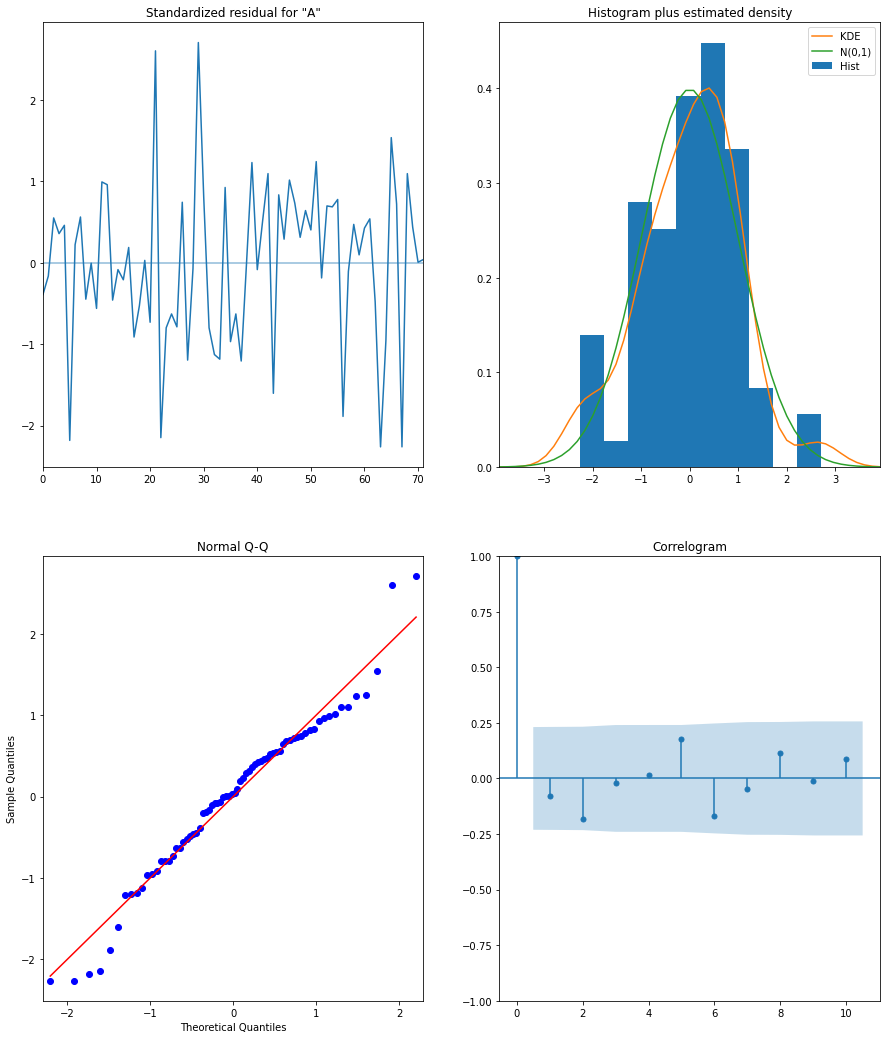

In [111]:
 AR_output = arima(qb_ts['Aaron Rodgers (GB)'].dropna(), order=(0,0,0))

In [42]:
def ose_forecast(ts, output, neighborhood =''):
    '''
    Plot forecast with real and predicted data.
    
    Input:
        ts : Time series.
        output : SARIMAX model output. 
        neighborhood : Name of city for plot title. 
        
    Output:
        Prints RMSE.
        Plots real vs. model predicted plot.
    '''

    # Get predictions starting from 2019-06-30 and calculate confidence intervals
    
    pred = output.get_prediction(start=pd.to_datetime('2019-06-30'), dynamic=False)
        
    # Get the real and predicted values
    ts_forecasted = pred.predicted_mean
    ts_truth = ts['2019-06-30':].value
    
    # Calc RMSE
    mse = mean_squared_error(ts_truth, ts_forecasted)
    rmse = np.sqrt(mse)

    # Print RMSE
    print('The RMSE of our forecasts is {}'.format(round(rmse, 2)))

    # Confidence Intervals
    pred_conf = pred.conf_int()

    ### Plot real vs predicted w/ confidence intervals ###

    rcParams['figure.figsize'] = 15, 6

    # Plot observed values
    ax = ts['2017-06-30':].plot(label='observed')

    # Plot predicted values
    
    ts_forecasted.plot(ax=ax, label='one-step ahead forecast', alpha=0.5)

    # Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=.3)
        
    # Title
    ax.set_title(neighborhood)

    # Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Median Home Value (USD)')
    plt.legend()

    return plt.show()

In [86]:
qb_ts.tail(17)

Aaron Rodgers (GB)  Baker Mayfield (CAR)  Dak Prescott (DAL)  \
Date                                                                       
2021-09-06                26.8                  18.5                 8.5   
2021-09-09                 3.3                  13.6                28.4   
2021-09-23                19.0                  16.9                20.1   
2021-09-30                24.1                   9.3                27.0   
2021-10-07                20.8                  23.0                21.7   
2021-10-14                23.7                  13.2                27.8   
2021-10-21                24.7                   0.0                 0.0   
2021-10-28                15.7                   9.5                 0.0   
2021-11-04                 0.0                  16.7                19.9   
2021-11-11                11.5                   5.9                26.3   
2021-11-18                33.5                   9.9                 4.6   
2021-11-25                26.3                  12.3                25.3   
2021-12-02                 0.0                   0.0                12.2   
2021-12-09                29.6                  16.0                11.9   
2021-12-16                23.8                   0.0                10.6   
2021-12-23                20.0                  14.0                31.3   
2022-01-02                20.3                  15.0                23.0   

            Derek Carr (LV)  Deshaun Watson (CLE)  Jalen Hurts (PHI)  \
Date                                                                   
2021-09-06             24.2                   0.0               21.8   
2021-09-09             25.0                   0.0               28.8   
2021-09-23             22.2                   0.0               22.5   
2021-09-30             15.4                   0.0               28.2   
2021-10-07              8.2                   0.0               23.9   
2021-10-14             21.5                   0.0               26.0   
2021-10-21             20.0                   0.0               23.5   
2021-10-28              0.0                   0.0               11.2   
2021-11-04             12.3                   0.0               16.7   
2021-11-11             19.2                   0.0               19.6   
2021-11-18              9.6                   0.0               30.8   
2021-11-25             21.0                   0.0                9.9   
2021-12-02             12.4                   0.0                0.0   
2021-12-09             11.5                   0.0                0.0   
2021-12-16             11.1                   0.0               28.6   
2021-12-23              9.5                   0.0               16.7   
2022-01-02             12.2                   0.0               13.0   

            Jameis Winston (NO)  Joe Burrow (CIN)  Josh Allen (BUF)  \
Date                                                                  
2021-09-06                 10.3              13.3              17.7   
2021-09-09                 29.6              18.6              17.2   
2021-09-23                 13.5              18.6              37.2   
2021-09-30                 13.0              22.3              21.0   
2021-10-07                 26.8              20.3              36.5   
2021-10-14                  0.0              23.8              29.7   
2021-10-21                 16.9              27.6               0.0   
2021-10-28                 10.2              21.3              29.5   
2021-11-04                  0.0               9.4              11.6   
2021-11-11                  0.0               0.0              21.9   
2021-11-18                  0.0               9.0              18.2   
2021-11-25                  0.0              17.4              28.7   
2021-12-02                  0.0              18.6              11.7   
2021-12-09                  0.0              22.2              36.2   
2021-12-16                  0.0              12.8             

In [91]:
# Forecast 5 year predictions - Home Sale Values #

def dynamic_forecast(ts, model_output, years=1, player='', save_fig=False):
    '''
    Plots dynamic forecast for specified time into the future.
    
    Inputs: 
        ts : Time series data.
        model_output : Output results from our model.
        years : n-years to forcast into the future.
        neighborhood: Name of neighborhood for plots
            
    Outputs:
        Prints : Time series plot with one step ahead forecast.
        Returns : Dictionary of predictions.
    
    '''
    
    # Calcualte steps
    steps = years*17
    
    # Get forecast and confidence interval for steps ahead in future
    future = model_output.get_forecast(steps=steps, dynamic=True, full_results=True)
    future_conf = future.conf_int()
    
    ### Plot forecast ###
    
    # Observed
    ax = ts.plot(label='Observed', figsize=(12, 6))
    # Predicted
    future.predicted_mean.plot(ax=ax, label='dynamic forecast', alpha=0.9)

    # Confidence Intervals
    ax.fill_between(future_conf.index,
                    future_conf.iloc[:, 0],
                    future_conf.iloc[:, 1], color='k', alpha=.25)
    
    # Title
    ax.set_title(f"1 Year Forecast for {player}")
    
    # x & y-labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Median Home Sale Value (USD)')
    
    # Legend
    ax.legend()
    
    if save_fig:
        plt.savefig(f'./images/dynamic_forecast_{player}.jpeg')
    
    # Print plot
    plt.show()

    # Forecast prediction for n-years into the future
    forecast = future.predicted_mean[-1]
    maximum = future_conf.iloc[-1,1]
    minimum = future_conf.iloc[-1,0]
    
    # Create dictionary of predictions
    predictions = {}
    predictions['forecast'] = forecast.round()
    predictions['minimum'] = minimum.round()
    predictions['maximum'] = maximum.round()
    
    return predictions

In [115]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm



model = pm.auto_arima(qb_ts['Aaron Rodgers (GB)'].dropna(), start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

In [113]:
!pip install pmdarima

     |████████████████████████████████| 601 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 18.1 MB 15.3 MB/s eta 0:00:01
     |████████████████████████████████| 9.6 MB 16.6 MB/s eta 0:00:01
     |████████████████████████████████| 40 kB 8.0 MB/s eta 0:00:011
     |████████████████████████████████| 233 kB 17.2 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Attempting uninstall: packaging
    Found existing installation: packaging 20.4
    Uninstalling packaging-20.4:
      Successfully uninstalled packaging-20.4
  Attempting uninstall: patsy
    Found existing installation: patsy 0.5.1
    Uninstalling patsy-0.5.1:
      Successfully uninstalled patsy-0.5.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.0
    Uninstalling statsmodels-0.12.0:
      Successfully uninstalled statsmodels-0.12.0
ERROR: After October 

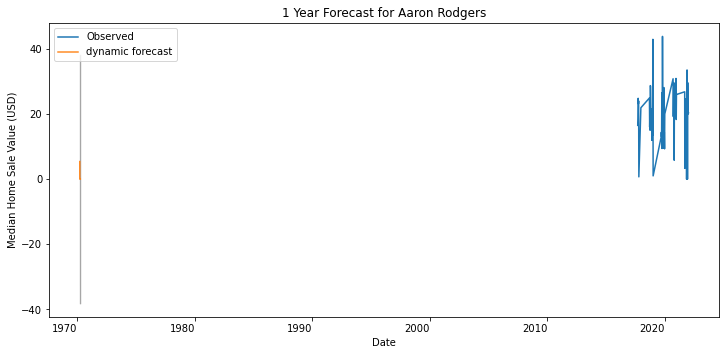

KeyError: -1

In [92]:
dynamic_forecast(qb_ts['Aaron Rodgers (GB)'].dropna(), AR_output, years=1, player='Aaron Rodgers', save_fig=False)


#### Arena District

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6052      0.063      9.657      0.000       0.482       0.728
ma.L1          0.0708      0.099      0.715      0.475      -0.123       0.265
ma.S.L12      -0.4880      0.025    -19.377      0.000      -0.537      -0.439
sigma2      1.354e+06   7.35e+04     18.427      0.000    1.21e+06     1.5e+06


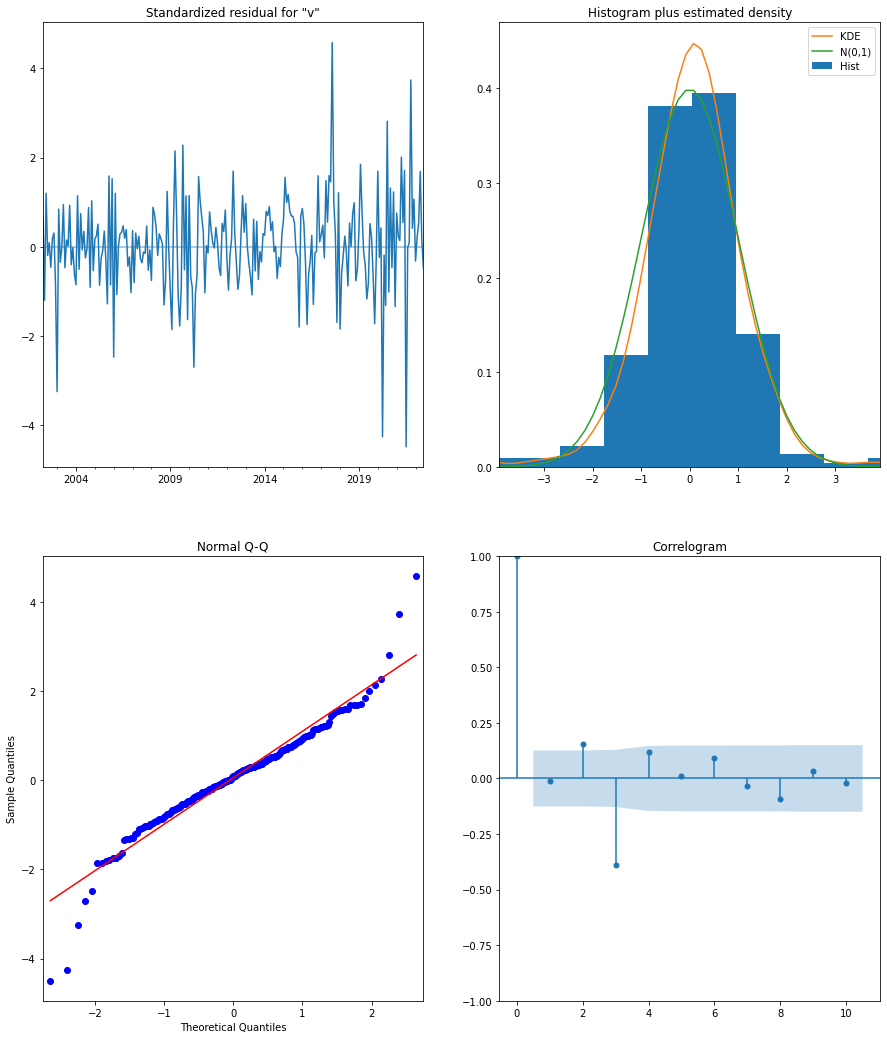

In [44]:
arena_district = zip_df[0]
output_arena_district = sarimax(arena_district, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))

The residuals look normally distributed, even though there are some heavy outliers presence in the tails of the Q-Q plot. We are likely going to see this in several of our following models.  This is due to the model being "confused" over the dip after the housing bubble, and the huge increases that have taken place in this area over the last few years.
We can see negative correlation in the correlogram at a month 3.  This makes sense knowing that we have seasonality in our data.  The ma.L1 has a p-value that is >0.05, and we will likely see this in all of our following zipcodes.  I am going to leave the model as is since I ran gridsearch to find optimal parameters.

The RMSE of our forecasts is 1816.45


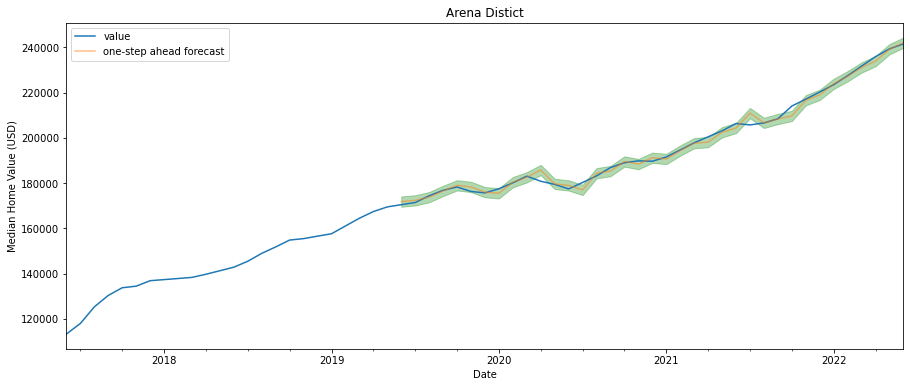

In [45]:
ose_forecast(arena_district, output_arena_district, neighborhood='Arena Distict')

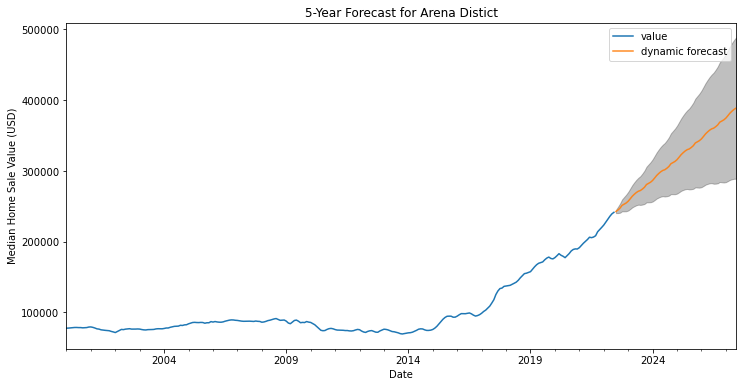

{'forecast': 388893.0, 'minimum': 289050.0, 'maximum': 488735.0}

In [46]:
dynamic_forecast(arena_district, output_arena_district, neighborhood='Arena Distict', years=5, save_fig=True)

The RMSE of our one step ahead forecast for the Arena District look great at $1,816! The confidence interval is small and the ROI of our minimum bounds are higher than the current value, which guarantees a positive ROI.  

#### Dignowity Hill

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4494      0.109      4.136      0.000       0.236       0.662
ma.L1          0.1275      0.130      0.981      0.326      -0.127       0.382
ar.S.L12      -0.3287      0.071     -4.651      0.000      -0.467      -0.190
ma.S.L12      -0.1885      0.049     -3.876      0.000      -0.284      -0.093
sigma2      1.045e+06    7.6e+04     13.747      0.000    8.96e+05    1.19e+06


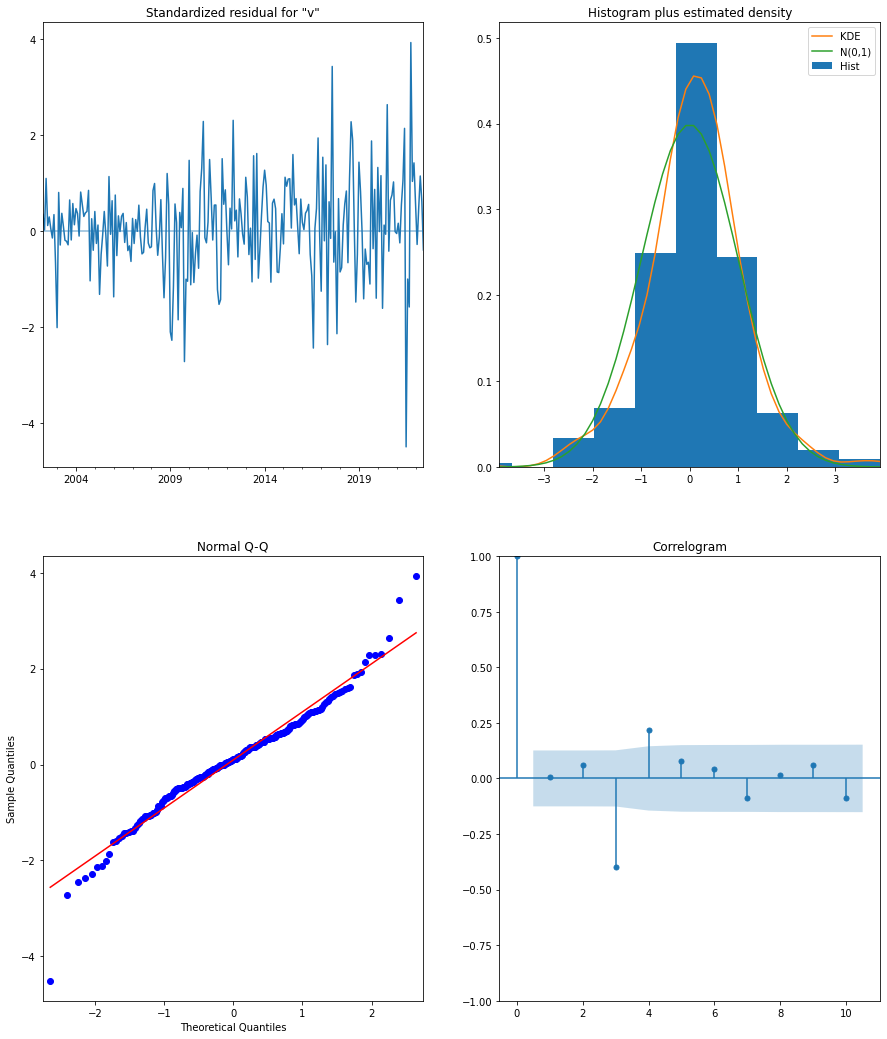

In [47]:
dig_hill = zip_df[1]
output_dig_hill = sarimax(dig_hill, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

The RMSE of our forecasts is 1446.54


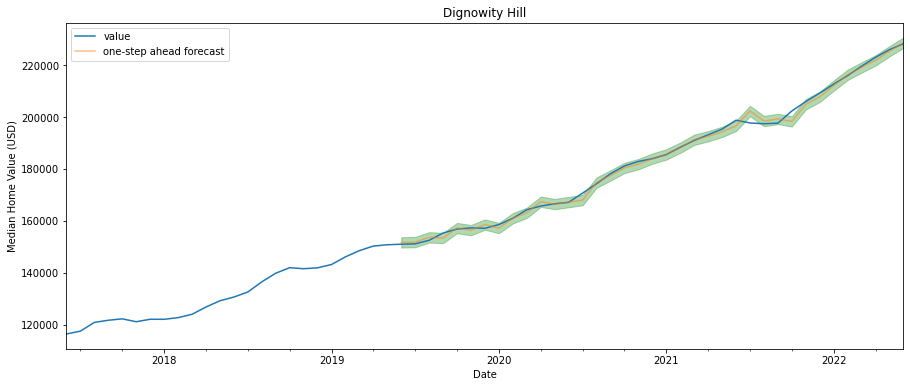

In [48]:
ose_forecast(dig_hill, output_dig_hill, neighborhood='Dignowity Hill')

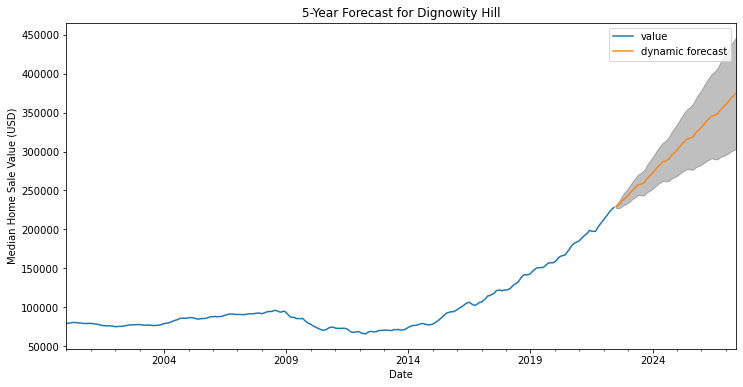

{'forecast': 374878.0, 'minimum': 303162.0, 'maximum': 446593.0}

In [49]:
dynamic_forecast(dig_hill, output_dig_hill, neighborhood='Dignowity Hill', years=5, save_fig=True)

Once again, we see negative correlation at month 3, this should be expected with all of the rest of our zipcode plots.  The residuals do have a few tail outliers, but are distributed normally.  The confidence interval of our forecasts is smaller than what we saw in the Arena District, and the RMSE is lower at $1446.  

#### Gardendale / Brady Gardens

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7256      0.049     14.850      0.000       0.630       0.821
ma.L1          0.0109      0.070      0.156      0.876      -0.126       0.147
ma.S.L12      -0.6518      0.043    -15.195      0.000      -0.736      -0.568
sigma2      3.649e+05    3.2e+04     11.394      0.000    3.02e+05    4.28e+05


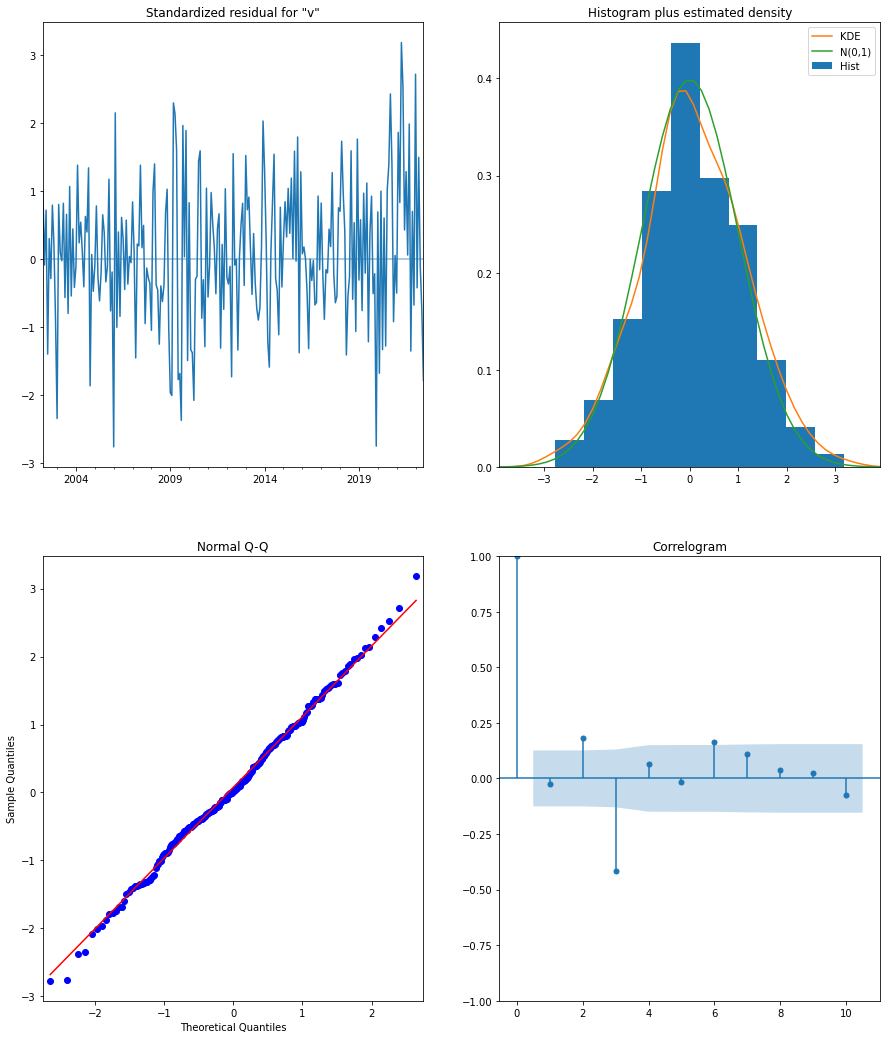

In [50]:
b_gardens = zip_df[2]
output_b_gardens = sarimax(b_gardens, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))

The RMSE of our forecasts is 856.1


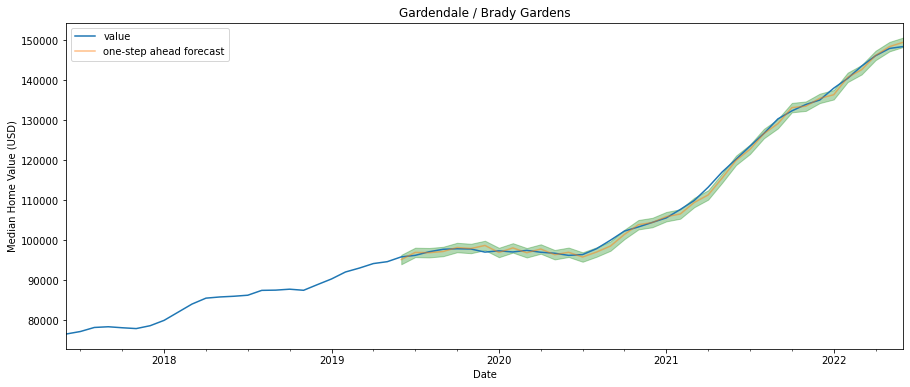

In [51]:
ose_forecast(b_gardens, output_b_gardens, neighborhood='Gardendale / Brady Gardens')

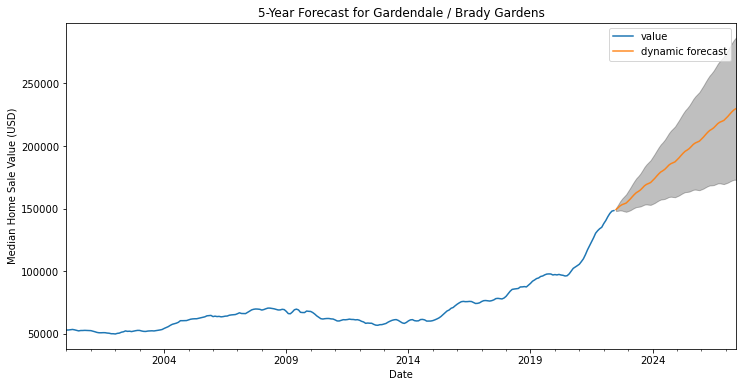

{'forecast': 229884.0, 'minimum': 173058.0, 'maximum': 286710.0}

In [52]:
dynamic_forecast(b_gardens, output_b_gardens, neighborhood='Gardendale / Brady Gardens', years=5)

Once again, we achieved a lower RMSE for Gardendale area at $856.  The residuals are normally distributed without any significant outliers.  

#### Kingsbury

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6708      0.102      6.553      0.000       0.470       0.871
ma.L1          0.0476      0.137      0.348      0.728      -0.221       0.316
ar.S.L12      -0.5986      0.112     -5.325      0.000      -0.819      -0.378
ma.S.L12      -0.0105      0.061     -0.171      0.864      -0.131       0.110
sigma2      2.151e+07   2.25e-09   9.56e+15      0.000    2.15e+07    2.15e+07


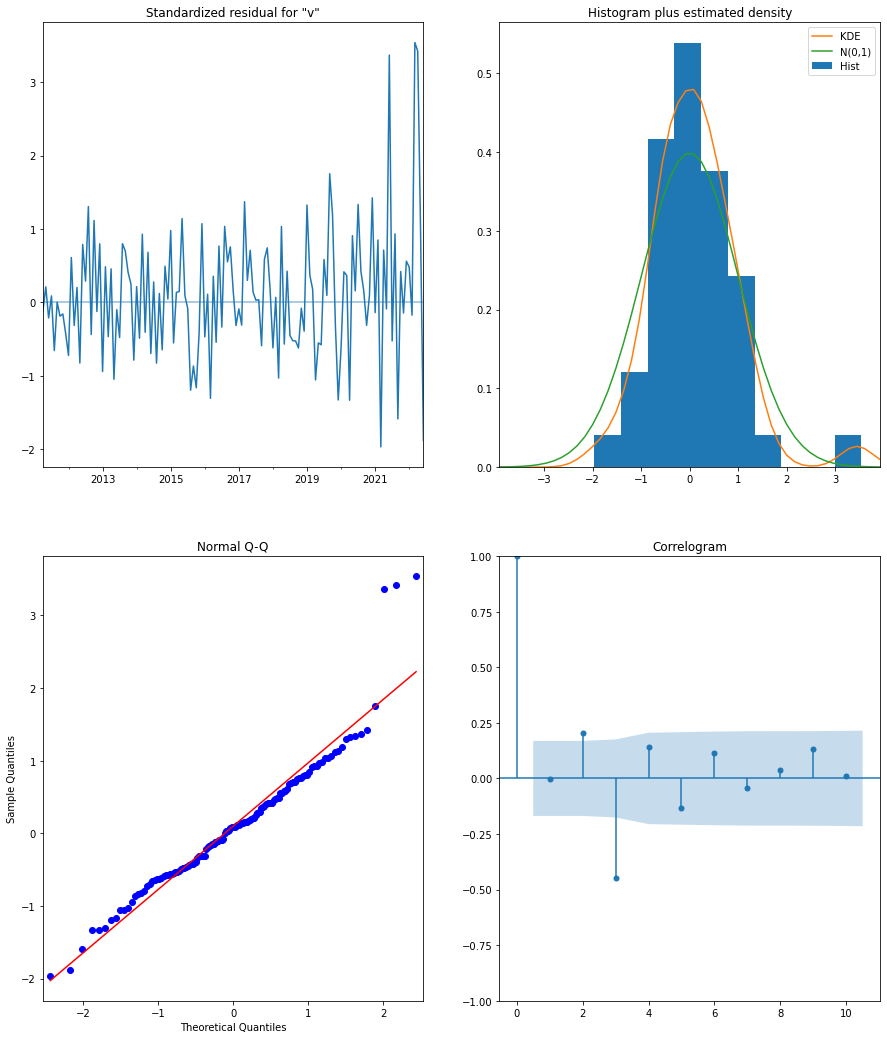

In [53]:
kingsbury = zip_df[3]
output_kingsbury = sarimax(kingsbury, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

The RMSE of our forecasts is 6104.66


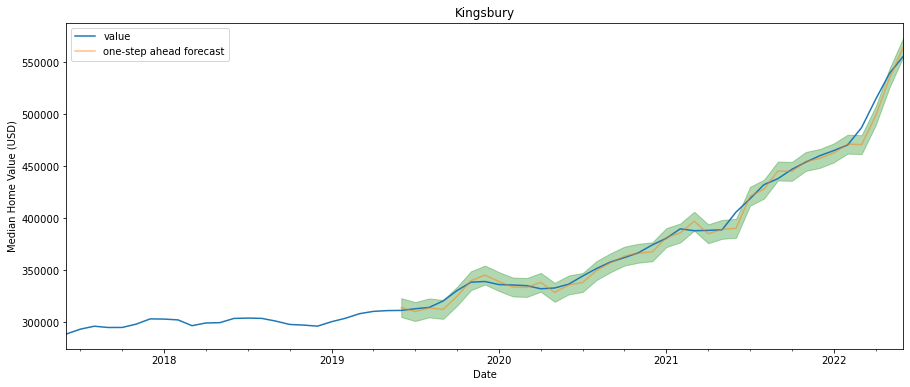

In [54]:
ose_forecast(kingsbury, output_kingsbury, neighborhood='Kingsbury')

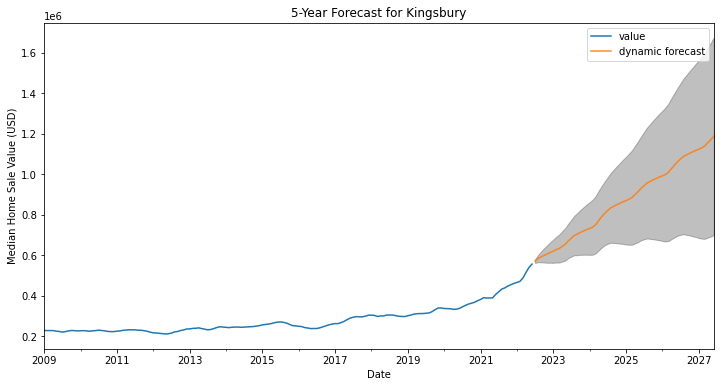

{'forecast': 1187524.0, 'minimum': 698989.0, 'maximum': 1676059.0}

In [55]:
dynamic_forecast(kingsbury, output_kingsbury, neighborhood='Kingsbury', years=5)

The RMSE of our predictions is $6,104 which is higher than our other zipcodes but the price of the homes are much higher in Kingsbury than the other areas.  However, Kingsbury has some pretty significant outliers on the high end which is skewing the distribution of the residuals.

#### Medina

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6341      0.093      6.837      0.000       0.452       0.816
ma.L1          0.0627      0.119      0.527      0.599      -0.171       0.296
ma.S.L12      -0.2064      0.039     -5.249      0.000      -0.284      -0.129
sigma2      2.866e+06   3.32e+05      8.626      0.000    2.21e+06    3.52e+06


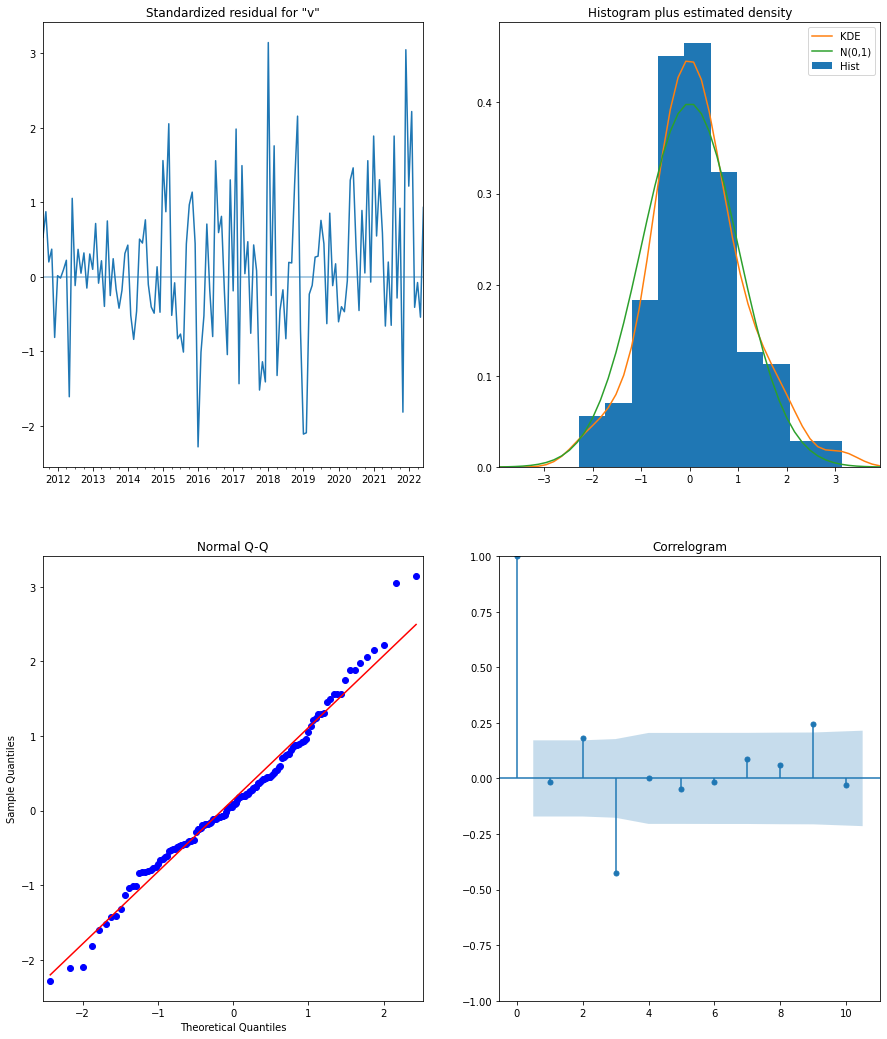

In [56]:
medina = zip_df[4]
output_medina = sarimax(medina, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))

The RMSE of our forecasts is 1798.26


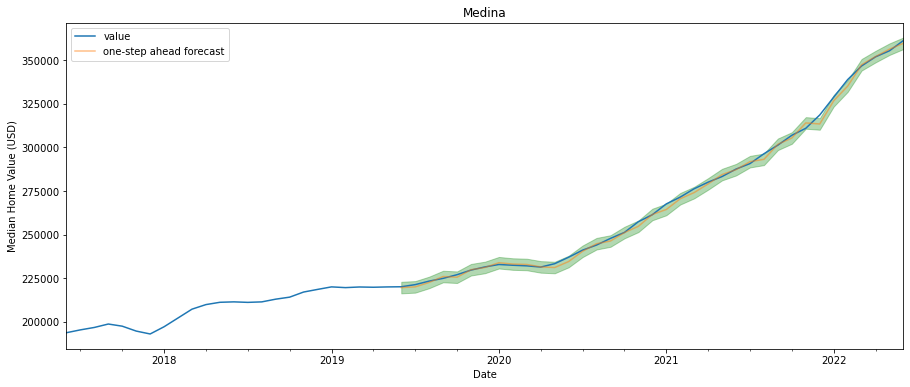

In [57]:
ose_forecast(medina, output_medina, neighborhood='Medina')

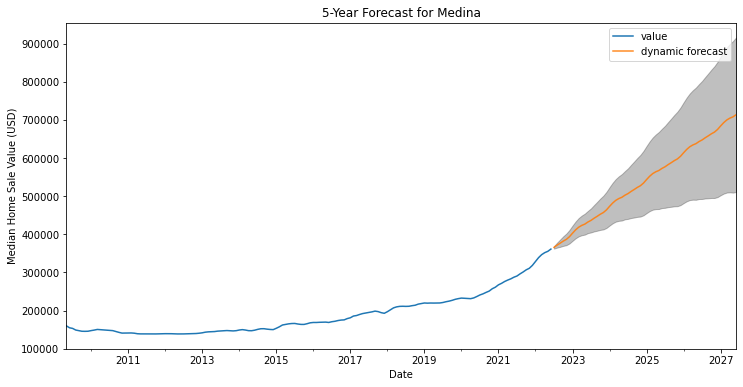

{'forecast': 713491.0, 'minimum': 510850.0, 'maximum': 916132.0}

In [58]:
dynamic_forecast(medina, output_medina, neighborhood='Medina', years=5)

The RMSE of our predictions for Medina is $1,798, which is similar to some of our other zipcodes we have already seen, and we can see the presence of a few outliers in the Q-Q plot.

#### Denver Heights / Highland Park

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6916      0.040     17.311      0.000       0.613       0.770
ma.L1          0.1066      0.067      1.597      0.110      -0.024       0.237
ma.S.L12      -0.5716      0.034    -16.696      0.000      -0.639      -0.504
sigma2       4.35e+05   3.03e+04     14.333      0.000    3.76e+05    4.94e+05


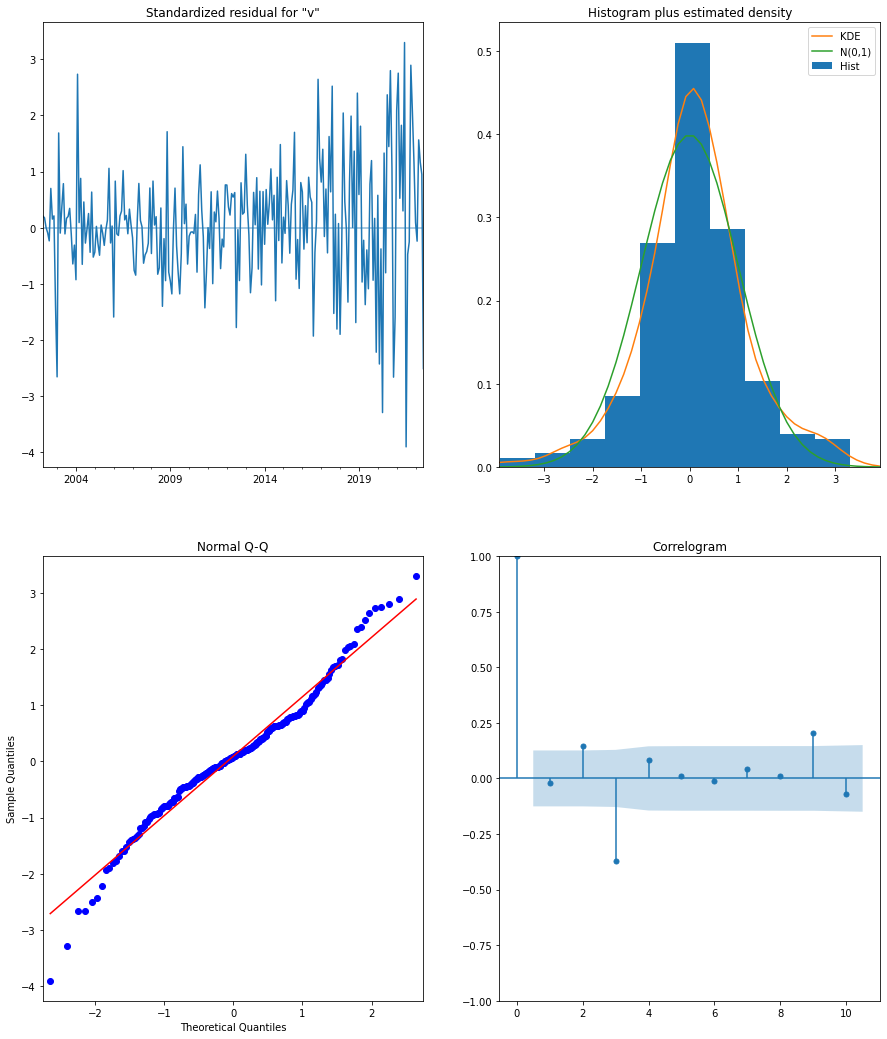

In [59]:
highland_park = zip_df[5]
output_highland_park = sarimax(highland_park, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))

The RMSE of our forecasts is 1198.29


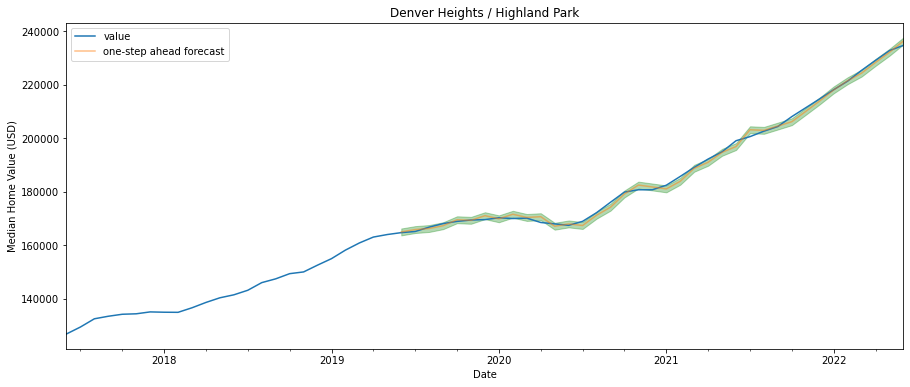

In [60]:
ose_forecast(highland_park, output_highland_park, neighborhood='Denver Heights / Highland Park')

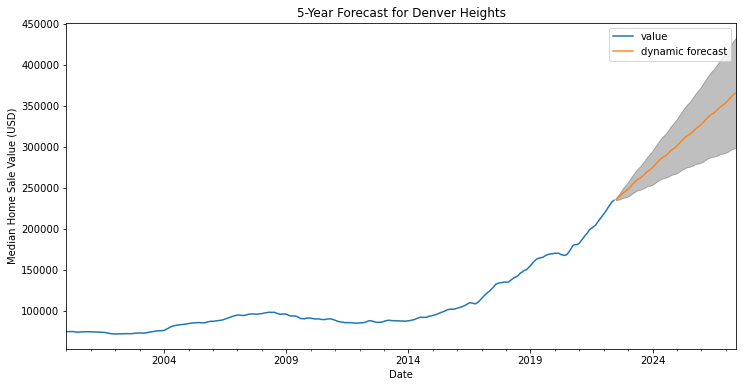

{'forecast': 366017.0, 'minimum': 298896.0, 'maximum': 433138.0}

In [61]:
dynamic_forecast(highland_park, output_highland_park, neighborhood='Denver Heights', years=5, save_fig=True)

Once again, residuals are mostly normal with outliers on the tails.  The RMSE of our predictions is $1198. The confidence interval appears to be smaller than several others we have seen.

#### Inner Westside

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6936      0.065     10.635      0.000       0.566       0.821
ma.L1          0.0103      0.096      0.108      0.914      -0.177       0.198
ar.S.L12      -0.4601      0.063     -7.347      0.000      -0.583      -0.337
ma.S.L12      -0.1084      0.034     -3.156      0.002      -0.176      -0.041
sigma2      4.368e+05   3.72e+04     11.730      0.000    3.64e+05     5.1e+05


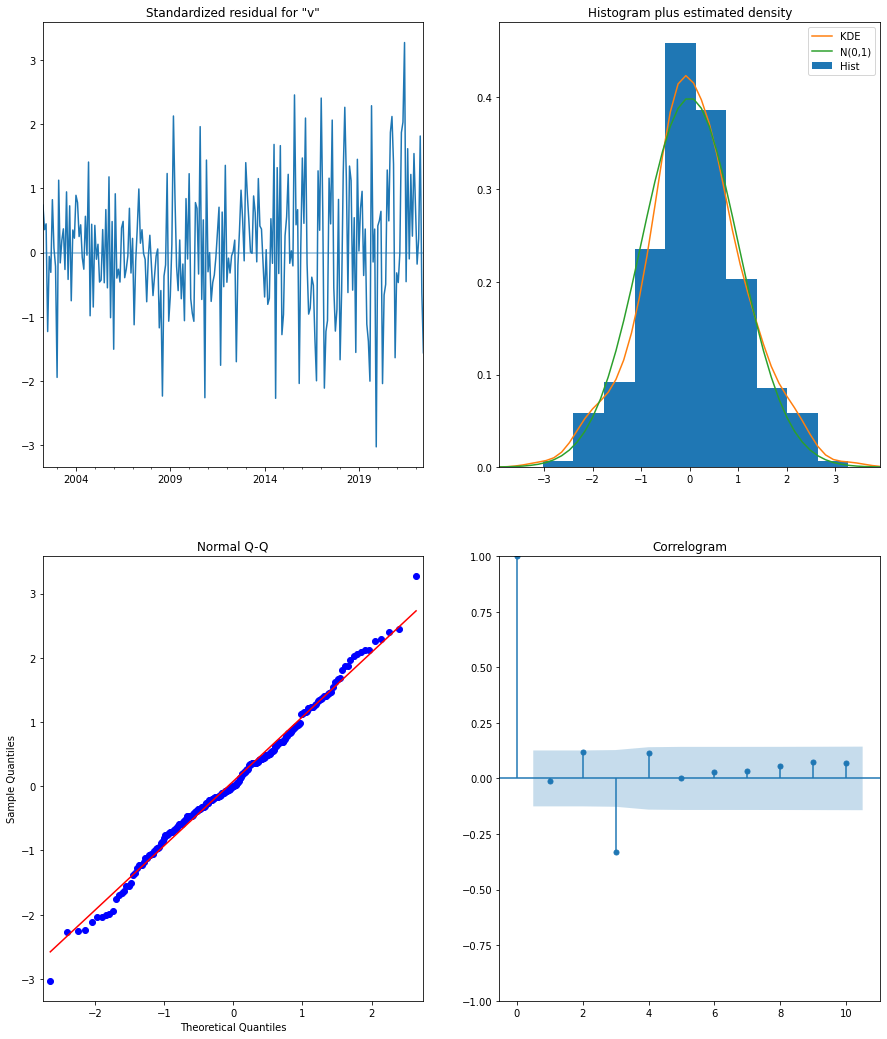

In [62]:
inner_westside = zip_df[6]
output_inner_westside = sarimax(inner_westside, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

The RMSE of our forecasts is 933.67


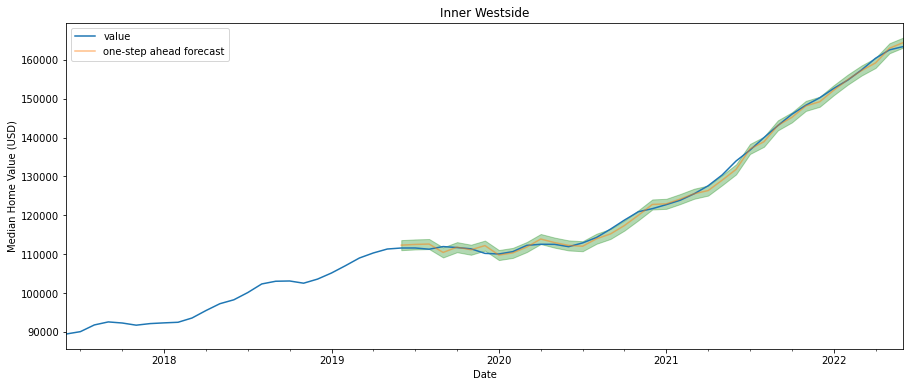

In [63]:
ose_forecast(inner_westside, output_inner_westside, neighborhood='Inner Westside')

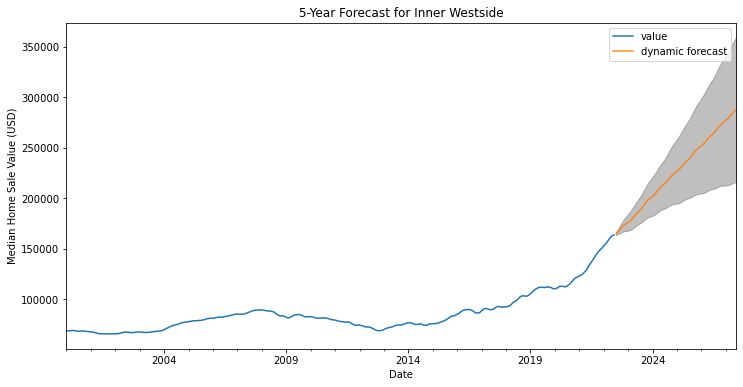

{'forecast': 287589.0, 'minimum': 215798.0, 'maximum': 359380.0}

In [64]:
dynamic_forecast(inner_westside, output_inner_westside, neighborhood='Inner Westside', years=5, save_fig=True)

The residuals are normal for the inner westside zipcode, and we have an RMSE of $933.  The price point for this neighborhood is is around 150k right now, with the forecast expected to increase to 287k in 5 years.  

#### Fisher

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8604      0.033     25.747      0.000       0.795       0.926
ma.L1          0.1090      0.075      1.456      0.145      -0.038       0.256
ar.S.L12      -0.6351      0.085     -7.473      0.000      -0.802      -0.469
ma.S.L12       0.0176      0.046      0.385      0.700      -0.072       0.108
sigma2      2.488e+06   2.55e+05      9.751      0.000    1.99e+06    2.99e+06


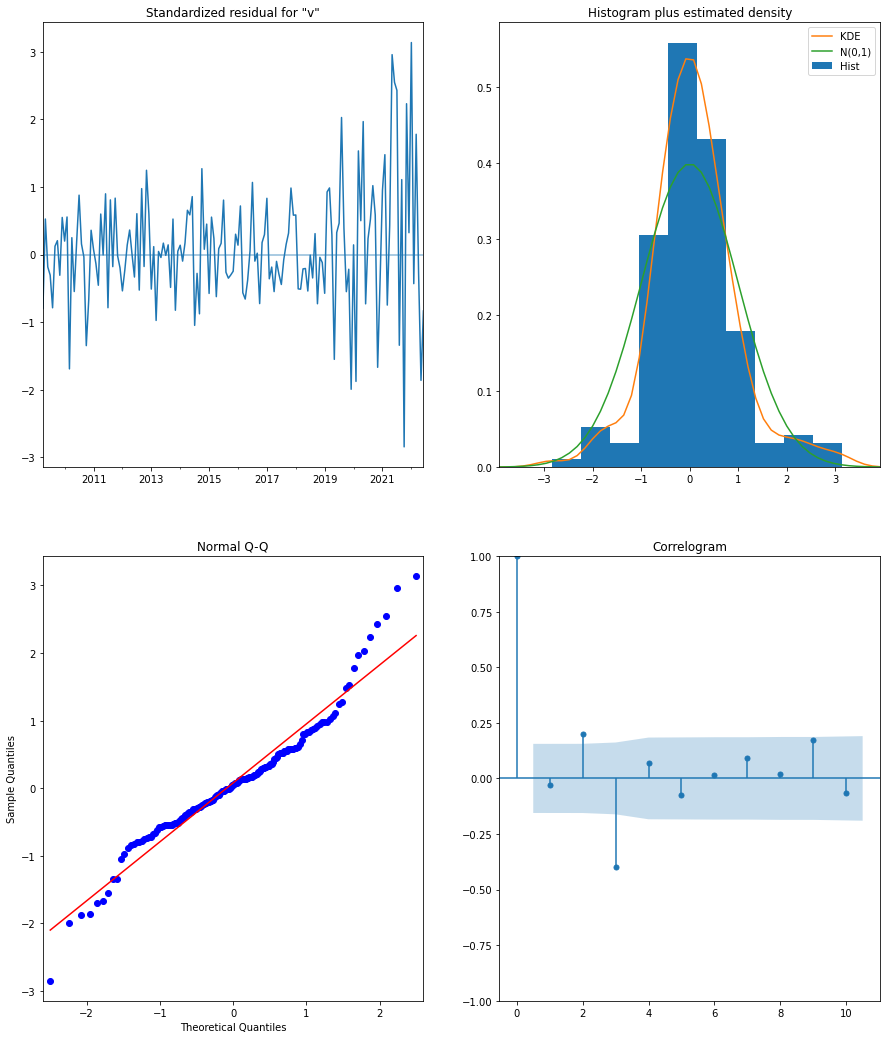

In [65]:
fisher = zip_df[7]
output_fisher = sarimax(fisher, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

The RMSE of our forecasts is 2358.43


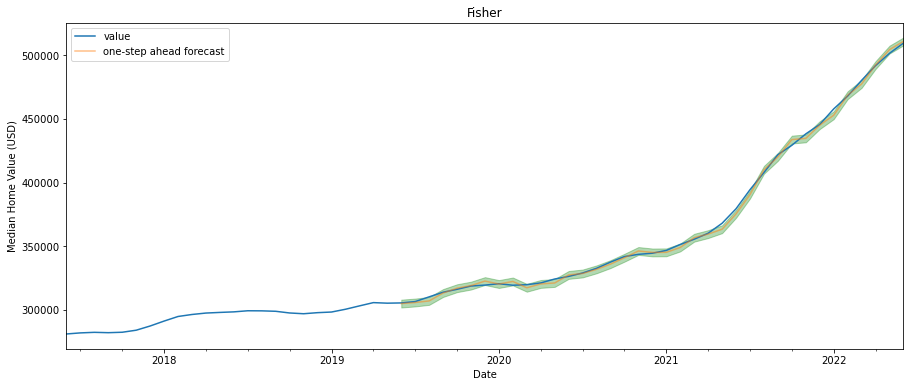

In [66]:
ose_forecast(fisher, output_fisher, neighborhood='Fisher')

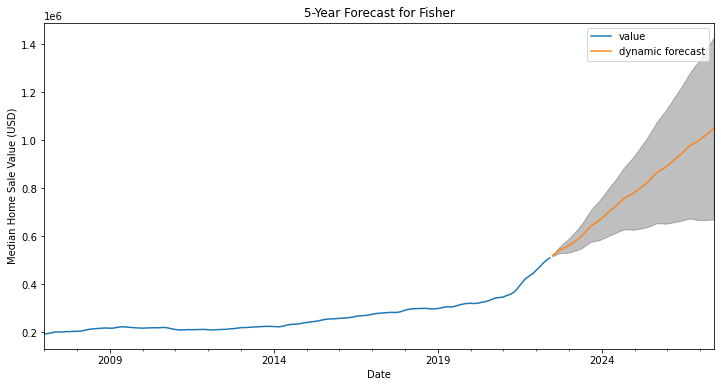

{'forecast': 1048416.0, 'minimum': 669827.0, 'maximum': 1427004.0}

In [67]:
dynamic_forecast(fisher, output_fisher, neighborhood='Fisher', years=5)

We can see the presence of heavy outliers.  This is an area that is relatively new near Canyon Lake.  There are many custom luxury homes in the area due to its location near the lake.  The RMSE of our predictions is $2358. The confidence interval for our forecasts is very large, which means there is a large amount of uncertainty.  The median home value has shot up 150k in the past 2 years due to it becoming a highly desirable area for retirees.  While the gains could be huge in this area, it is not likely to be the safest investment based on the very steep increase over the past 2 years which could taper off.

#### Canyon Lake

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9157      0.061     14.986      0.000       0.796       1.035
ma.L1          0.1537      0.137      1.121      0.262      -0.115       0.422
ar.S.L12      -0.7337      0.125     -5.855      0.000      -0.979      -0.488
ma.S.L12      -0.0034      0.067     -0.052      0.959      -0.134       0.127
sigma2      2.152e+06   3.35e+05      6.429      0.000     1.5e+06    2.81e+06


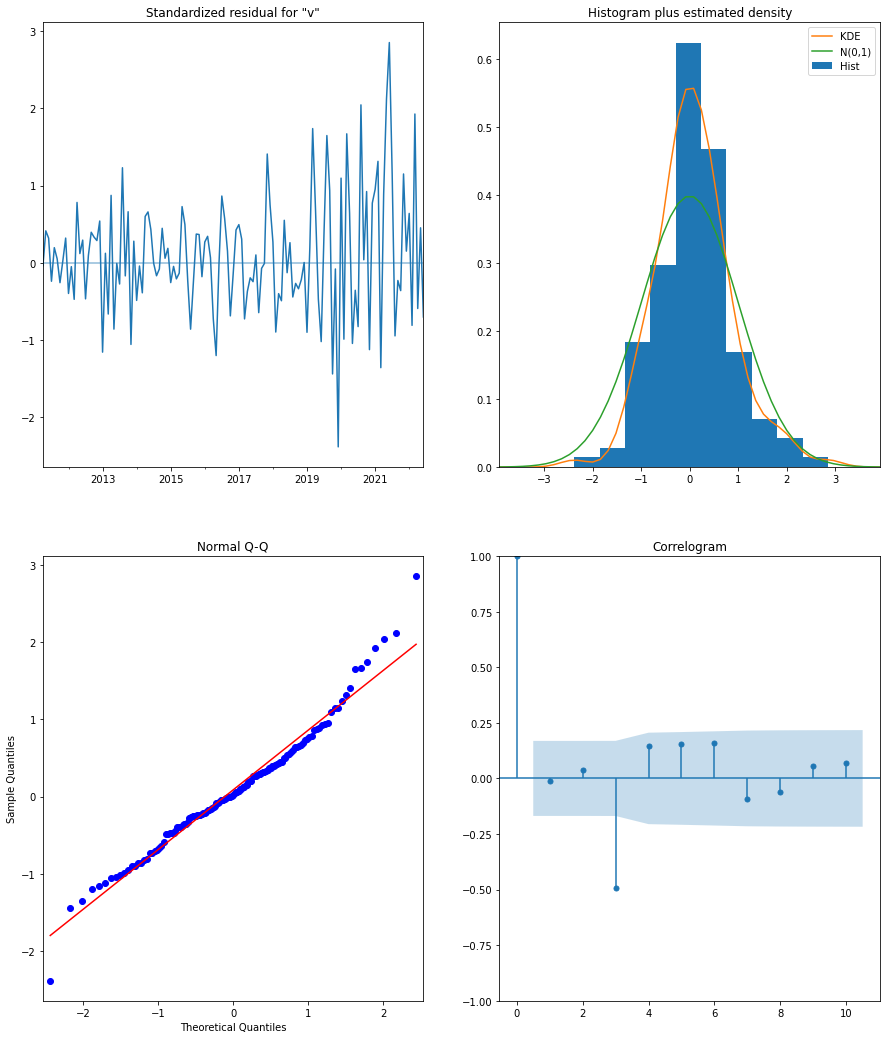

In [68]:
canyon_lake = zip_df[8]
output_canyon_lake = sarimax(canyon_lake, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

The RMSE of our forecasts is 1773.47


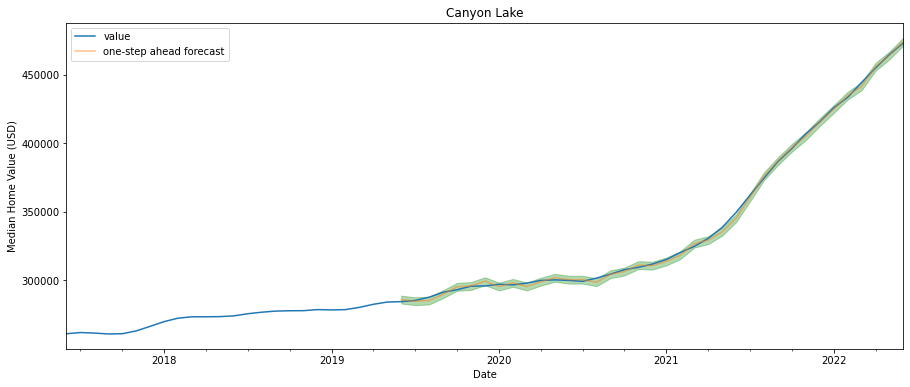

In [69]:
ose_forecast(canyon_lake, output_canyon_lake, neighborhood='Canyon Lake')

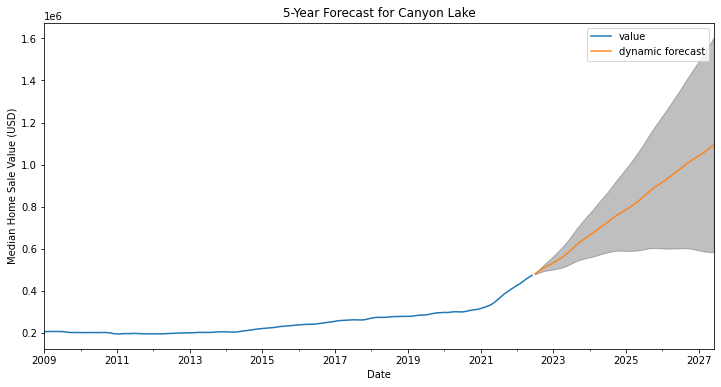

{'forecast': 1093740.0, 'minimum': 582966.0, 'maximum': 1604515.0}

In [70]:
dynamic_forecast(canyon_lake, output_canyon_lake, neighborhood='Canyon Lake', years=5)

We can see the same thing happening in Canyon Lake, the median value of homes has shot up 150k in the past year, and Canyon Lake also has a high entry point into the market right now.  Due to the high increases in the past year, the confidence interval is very large for Canyon Lake and this would be a riskier investment.  There is a spread of 1 million dollars in our confidence interval!

#### Eastside

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6822      0.051     13.399      0.000       0.582       0.782
ma.L1          0.0998      0.078      1.284      0.199      -0.053       0.252
ar.S.L12      -0.5868      0.054    -10.903      0.000      -0.692      -0.481
ma.S.L12      -0.1070      0.034     -3.151      0.002      -0.174      -0.040
sigma2      3.593e+05   2.94e+04     12.241      0.000    3.02e+05    4.17e+05


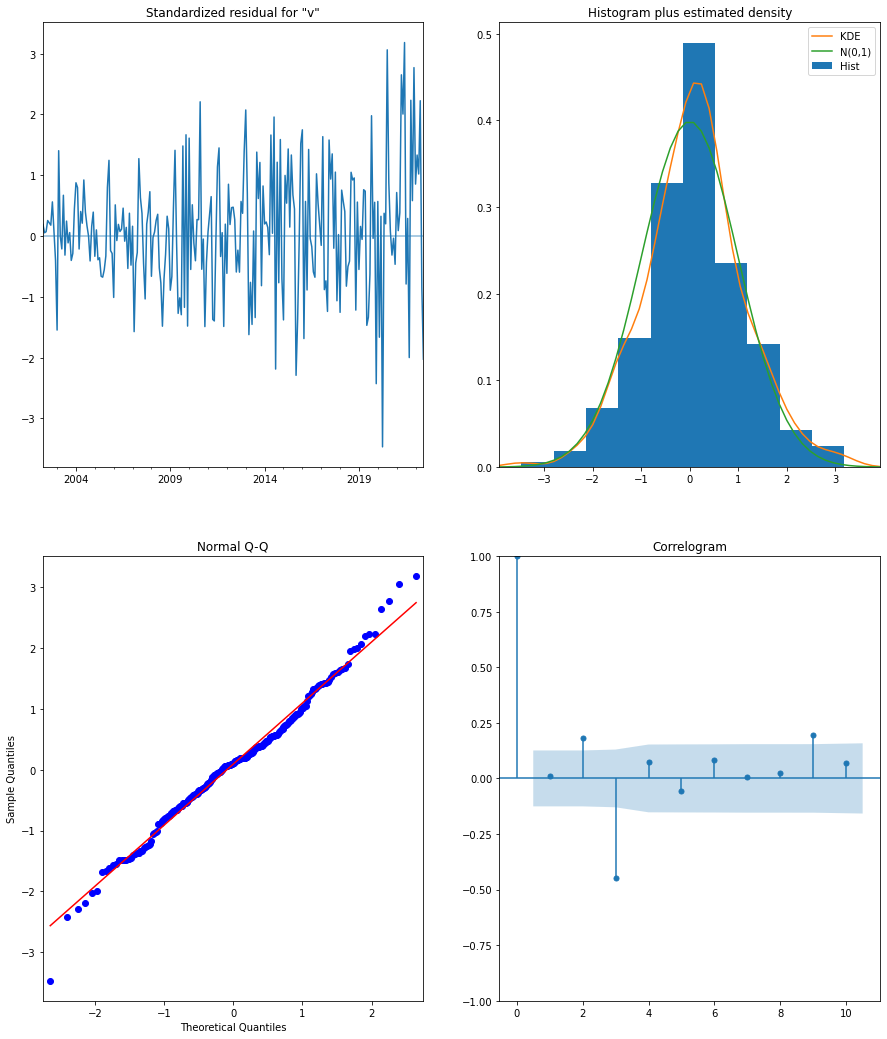

In [71]:
eastside = zip_df[9]
output_eastside = sarimax(eastside, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

The RMSE of our forecasts is 951.41


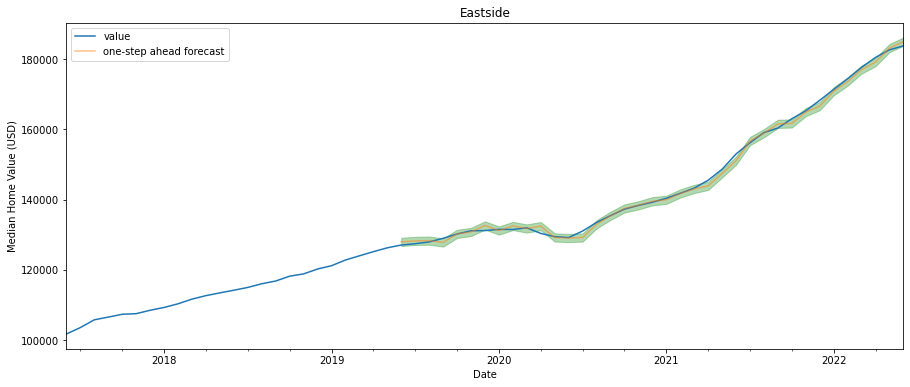

In [72]:
ose_forecast(eastside, output_eastside, neighborhood='Eastside')

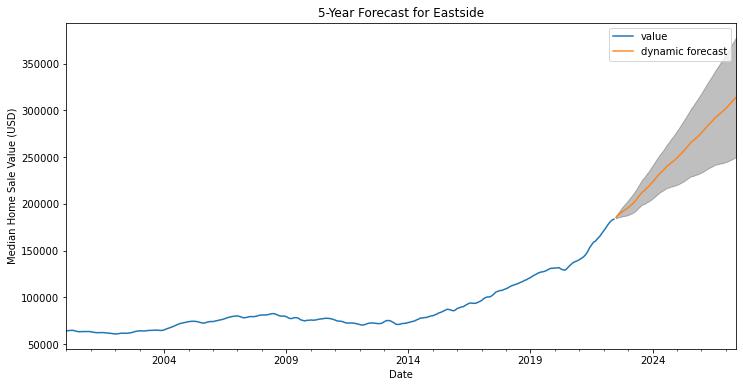

{'forecast': 313952.0, 'minimum': 249978.0, 'maximum': 377926.0}

In [73]:
dynamic_forecast(eastside, output_eastside, neighborhood='Eastside', years=5, save_fig=True)

The RMSE of our predictions for the Eastside is $951, with a relatively small confidence interval for our forecasts.  The entry point into the neighborhood is low at around 180k, with our 5 year forecast predicting to increase to 313k.  The residuals are normal with some outliers on the tails.  

## Interpret Results

### Projections for 3 and 5 year ROI

I am now going to make a dataframe that will contain our projected metrics based upon our sarimax model forecasting.

In [74]:
def projections(ts, zipcodes, years):
    '''
    Calculate projections for each zip code.
        - Current Value
        - ROI (return on investment)
        
    Input:
        ts : time series data.
        zipcodes : list of zip codes to iterate through.
        years : n-number of years to forecast.
        
    Output:
        Returns dataframe with:
        - zip code
        - investment value (current value)
        - predicted value and errors
        - predicted ROI and errors

    '''
    
    # Define steps for forecasting
    steps = years*12
    
    # Create list to append projection metrics
    projections = []
    
    # Iterate through time series of each zip code
    for zipcode in zipcodes:
        
        # Time series of zip code
        zip_ts = ts[ts['RegionName'] == zipcode]
        to_drop = ['RegionName']
        zip_ts = zip_ts.drop(to_drop, axis=1)
        
        # Plug the optimal parameter values into a new SARIMAX model
        # I used the values that were the most frequent for out top 10 zipcodes
        SARIMAX = sm.tsa.statespace.SARIMAX(zip_ts,
                                            order=(1, 1, 1),
                                            seasonal_order=(1, 1, 1, 12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

        # Fit the model and print results
        output = SARIMAX.fit()
    
        # Get forecast and confidence interval for steps ahead in future
        forecast = output.get_forecast(steps=steps, dynamic=True)
        conf_int = forecast.conf_int()

        # Show prediction for end of step-period
        pred_mean = forecast.predicted_mean[-1]
        pred_mean_min = conf_int.iloc[-1,0]
        pred_mean_max = conf_int.iloc[-1,1]
        
        # Last value of the time series - this will be used to calculate projected ROI
        current_value = zip_ts['value'][-1]
        
        # ROI (Return on Investment) as Percentage
        ROI = ((pred_mean-current_value)/current_value *100)
        ROI_min = ((pred_mean_min-current_value)/current_value *100)
        ROI_max = ((pred_mean_max-current_value)/current_value *100)
        
        # Create DataFrame
        
        # Initiate empty dictionary
        predicted = {}

        # Columns for df
        predicted['Zip Code'] = zipcode
        predicted['Investment Value ($)'] = current_value.round(2)
        predicted['Predicted Sale Price ($)'] = pred_mean.round(2)
        predicted['Min Pred Sale Price ($)'] = pred_mean_min.round(2)
        predicted['Max Pred Sale Price ($)'] = pred_mean_max.round(2)
        predicted['Predicted ROI (%)'] = ROI.round()
        predicted['Min Pred ROI (%)'] = ROI_min.round()
        predicted['Max Pred ROI (%)'] = ROI_max.round()
        
        # Append to list
        projections.append(predicted)
        
        # Return in DataFrame format     
    return pd.DataFrame.from_dict(projections)

In [75]:
# Get 3 year projections for top 10 zip codes
three_year_projections = projections(model_df, zip_list, years=3)
three_year_projections

Zip Code  Investment Value ($)  Predicted Sale Price ($)  \
0     78203              241568.0                 339839.66   
1     78202              228219.0                 316210.20   
2     78207              148461.0                 217501.24   
3     78638              555727.0                 930184.77   
4     78055              361314.0                 569344.07   
5     78210              234712.0                 337287.14   
6     78237              163415.0                 237227.36   
7     78623              509544.0                 827218.41   
8     78133              473175.0                 837285.82   
9     78220              183720.0                 260936.10   

   Min Pred Sale Price ($)  Max Pred Sale Price ($)  Predicted ROI (%)  \
0                283808.21                395871.11               41.0   
1                277737.86                354682.55               39.0   
2                180366.22                254636.25               47.0   
3                673410.44               1186959.09               67.0   
4                465645.71                673042.44               58.0   
5                295798.77                378775.51               44.0   
6                199425.67                275029.05               45.0   
7                638932.68               1015504.15               62.0   
8                594395.25               1080176.39               77.0   
9                226854.29                295017.91               42.0   

   Min Pred ROI (%)  Max Pred ROI (%)  
0              17.0              64.0  
1              22.0              55.0  
2              21.0              72.0  
3              21.0             114.0  
4              29.0              86.0  
5              26.0              61.0  
6              22.0              68.0  
7              25.0              99.0  
8              26.0             128.0  
9              23.0              61.0

In [76]:
# Make column for neighborhood name
# Top 10 zip code names        
top_10_names =  ['Arena District', 'Dignowity Hill', 'Gardendale', 'Kingsbury', 'Medina', 
                 'Denver Heights', 'Inner Westside', 'Fisher', 'Canyon Lake', 'Eastside']
three_year_projections['Neighborhood'] = top_10_names
three_year_projections = three_year_projections.reindex(columns=['Neighborhood', 'Zip Code', 'Investment Value ($)',
                                                                 'Predicted Sale Price ($)', 'Min Pred Sale Price ($)',
                                                                 'Max Pred Sale Price ($)', 'Predicted ROI (%)', 
                                                                 'Min Pred ROI (%)', 'Max Pred ROI (%)'])
three_year_projections.set_index('Neighborhood')

Zip Code  Investment Value ($)  Predicted Sale Price ($)  \
Neighborhood                                                               
Arena District     78203              241568.0                 339839.66   
Dignowity Hill     78202              228219.0                 316210.20   
Gardendale         78207              148461.0                 217501.24   
Kingsbury          78638              555727.0                 930184.77   
Medina             78055              361314.0                 569344.07   
Denver Heights     78210              234712.0                 337287.14   
Inner Westside     78237              163415.0                 237227.36   
Fisher             78623              509544.0                 827218.41   
Canyon Lake        78133              473175.0                 837285.82   
Eastside           78220              183720.0                 260936.10   

                Min Pred Sale Price ($)  Max Pred Sale Price ($)  \
Neighborhood                                                       
Arena District                283808.21                395871.11   
Dignowity Hill                277737.86                354682.55   
Gardendale                    180366.22                254636.25   
Kingsbury                     673410.44               1186959.09   
Medina                        465645.71                673042.44   
Denver Heights                295798.77                378775.51   
Inner Westside                199425.67                275029.05   
Fisher                        638932.68               1015504.15   
Canyon Lake                   594395.25               1080176.39   
Eastside                      226854.29                295017.91   

                Predicted ROI (%)  Min Pred ROI (%)  Max Pred ROI (%)  
Neighborhood                                                           
Arena District               41.0              17.0              64.0  
Dignowity Hill               39.0              22.0              55.0  
Gardendale                   47.0              21.0              72.0  
Kingsbury                    67.0              21.0             114.0  
Medina                       58.0              29.0              86.0  
Denver Heights               44.0              26.0              61.0  
Inner Westside               45.0              22.0              68.0  
Fisher                       62.0              25.0              99.0  
Canyon Lake                  77.0              26.0             128.0  
Eastside                     42.0              23.0              61.0

In [77]:
# Get 5 year projections for top 10 zip codes
five_year_projections = projections(model_df, zip_list, years=5)
five_year_projections

Zip Code  Investment Value ($)  Predicted Sale Price ($)  \
0     78203              241568.0                 405675.97   
1     78202              228219.0                 374877.90   
2     78207              148461.0                 264755.34   
3     78638              555727.0                1187523.76   
4     78055              361314.0                 708782.46   
5     78210              234712.0                 406120.38   
6     78237              163415.0                 287589.35   
7     78623              509544.0                1048415.61   
8     78133              473175.0                1093740.35   
9     78220              183720.0                 313951.99   

   Min Pred Sale Price ($)  Max Pred Sale Price ($)  Predicted ROI (%)  \
0                301026.60                510325.34               68.0   
1                303162.47                446593.33               64.0   
2                195127.43                334383.26               78.0   
3                698988.57               1676058.95              114.0   
4                507903.17                909661.75               96.0   
5                327701.41                484539.36               73.0   
6                215798.43                359380.27               76.0   
7                669826.72               1427004.49              106.0   
8                582965.84               1604514.85              131.0   
9                249978.26                377925.71               71.0   

   Min Pred ROI (%)  Max Pred ROI (%)  
0              25.0             111.0  
1              33.0              96.0  
2              31.0             125.0  
3              26.0             202.0  
4              41.0             152.0  
5              40.0             106.0  
6              32.0             120.0  
7              31.0             180.0  
8              23.0             239.0  
9              36.0             106.0

In [78]:
# Set neighborhood names for five year projections df
five_year_projections['Neighborhood'] = top_10_names
five_year_projections = five_year_projections.reindex(columns=['Neighborhood', 'Zip Code', 'Investment Value ($)',
                                                               'Predicted Sale Price ($)', 'Min Pred Sale Price ($)',
                                                               'Max Pred Sale Price ($)', 'Predicted ROI (%)', 
                                                               'Min Pred ROI (%)', 'Max Pred ROI (%)'])
five_year_projections.set_index('Neighborhood')

Zip Code  Investment Value ($)  Predicted Sale Price ($)  \
Neighborhood                                                               
Arena District     78203              241568.0                 405675.97   
Dignowity Hill     78202              228219.0                 374877.90   
Gardendale         78207              148461.0                 264755.34   
Kingsbury          78638              555727.0                1187523.76   
Medina             78055              361314.0                 708782.46   
Denver Heights     78210              234712.0                 406120.38   
Inner Westside     78237              163415.0                 287589.35   
Fisher             78623              509544.0                1048415.61   
Canyon Lake        78133              473175.0                1093740.35   
Eastside           78220              183720.0                 313951.99   

                Min Pred Sale Price ($)  Max Pred Sale Price ($)  \
Neighborhood                                                       
Arena District                301026.60                510325.34   
Dignowity Hill                303162.47                446593.33   
Gardendale                    195127.43                334383.26   
Kingsbury                     698988.57               1676058.95   
Medina                        507903.17                909661.75   
Denver Heights                327701.41                484539.36   
Inner Westside                215798.43                359380.27   
Fisher                        669826.72               1427004.49   
Canyon Lake                   582965.84               1604514.85   
Eastside                      249978.26                377925.71   

                Predicted ROI (%)  Min Pred ROI (%)  Max Pred ROI (%)  
Neighborhood                                                           
Arena District               68.0              25.0             111.0  
Dignowity Hill               64.0              33.0              96.0  
Gardendale                   78.0              31.0             125.0  
Kingsbury                   114.0              26.0             202.0  
Medina                       96.0              41.0             152.0  
Denver Heights               73.0              40.0             106.0  
Inner Westside               76.0              32.0             120.0  
Fisher                      106.0              31.0             180.0  
Canyon Lake                 131.0              23.0             239.0  
Eastside                     71.0              36.0             106.0

In [79]:
# Sort values based on ROI for 3 year projections
three_year_projections.sort_values('Predicted ROI (%)')

Neighborhood  Zip Code  Investment Value ($)  Predicted Sale Price ($)  \
1  Dignowity Hill     78202              228219.0                 316210.20   
0  Arena District     78203              241568.0                 339839.66   
9        Eastside     78220              183720.0                 260936.10   
5  Denver Heights     78210              234712.0                 337287.14   
6  Inner Westside     78237              163415.0                 237227.36   
2      Gardendale     78207              148461.0                 217501.24   
4          Medina     78055              361314.0                 569344.07   
7          Fisher     78623              509544.0                 827218.41   
3       Kingsbury     78638              555727.0                 930184.77   
8     Canyon Lake     78133              473175.0                 837285.82   

   Min Pred Sale Price ($)  Max Pred Sale Price ($)  Predicted ROI (%)  \
1                277737.86                354682.55               39.0   
0                283808.21                395871.11               41.0   
9                226854.29                295017.91               42.0   
5                295798.77                378775.51               44.0   
6                199425.67                275029.05               45.0   
2                180366.22                254636.25               47.0   
4                465645.71                673042.44               58.0   
7                638932.68               1015504.15               62.0   
3                673410.44               1186959.09               67.0   
8                594395.25               1080176.39               77.0   

   Min Pred ROI (%)  Max Pred ROI (%)  
1              22.0              55.0  
0              17.0              64.0  
9              23.0              61.0  
5              26.0              61.0  
6              22.0              68.0  
2              21.0              72.0  
4              29.0              86.0  
7              25.0              99.0  
3              21.0             114.0  
8              26.0             128.0

In [80]:
# Sort values based on ROI for 5 year projections
five_year_projections.sort_values('Predicted ROI (%)')

Neighborhood  Zip Code  Investment Value ($)  Predicted Sale Price ($)  \
1  Dignowity Hill     78202              228219.0                 374877.90   
0  Arena District     78203              241568.0                 405675.97   
9        Eastside     78220              183720.0                 313951.99   
5  Denver Heights     78210              234712.0                 406120.38   
6  Inner Westside     78237              163415.0                 287589.35   
2      Gardendale     78207              148461.0                 264755.34   
4          Medina     78055              361314.0                 708782.46   
7          Fisher     78623              509544.0                1048415.61   
3       Kingsbury     78638              555727.0                1187523.76   
8     Canyon Lake     78133              473175.0                1093740.35   

   Min Pred Sale Price ($)  Max Pred Sale Price ($)  Predicted ROI (%)  \
1                303162.47                446593.33               64.0   
0                301026.60                510325.34               68.0   
9                249978.26                377925.71               71.0   
5                327701.41                484539.36               73.0   
6                215798.43                359380.27               76.0   
2                195127.43                334383.26               78.0   
4                507903.17                909661.75               96.0   
7                669826.72               1427004.49              106.0   
3                698988.57               1676058.95              114.0   
8                582965.84               1604514.85              131.0   

   Min Pred ROI (%)  Max Pred ROI (%)  
1              33.0              96.0  
0              25.0             111.0  
9              36.0             106.0  
5              40.0             106.0  
6              32.0             120.0  
2              31.0             125.0  
4              41.0             152.0  
7              31.0             180.0  
3              26.0             202.0  
8              23.0             239.0

Our projections for 3 years and 5 years have the same ranking order of each zip code which is great. In order to aid visualization, I am going to write a function to produce a bar plot with predicted ROI and errors associated with each zip code.

### Barplots of ROI Projections and Errors

In [81]:
# Barplot for x years projection with 95% confidence intervals
def projection_barplot(df, years=3, save_fig=False):
    # Plot Predicted Mean Home Sale Values #

    # Get errors; (pred mean - lower bound of conf interval)
    errors = df['Predicted ROI (%)'] - df['Min Pred ROI (%)']
    df['errors'] = errors

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Plot barplot of ROI with errors
    plt.rcParams.update({'font.size': 18})
    df.plot(x='Neighborhood', 
            y='Predicted ROI (%)', 
            kind='bar',
            ax=ax, 
            color='none', 
            ecolor='black',
            capsize=10,
            yerr='errors', 
            legend=False)
    #Labels
    ax.set_xlabel('Neighborhood')
    ax.set_ylabel('Predicted ROI (%)')
    plt.title(f'{years} Year ROI w/ 95% Confidence Intervals')

    # Predicted ROI
    ax.scatter(x=pd.np.arange(df.shape[0]),
               marker='s', 
               s=40, 
               y=df['Predicted ROI (%)'], 
               color='black')
    
    # Line to help visualize on the y-axis
    ax.axhline(y=50, linestyle='--', color='red', linewidth=1.5)
    
    if save_fig:
        fig.savefig(f'./images/barplot_{years}.jpeg')
    
    # Rotate zip code labels 45 degrees
    plt.xticks(rotation = 45, size = 14)
    plt.show();

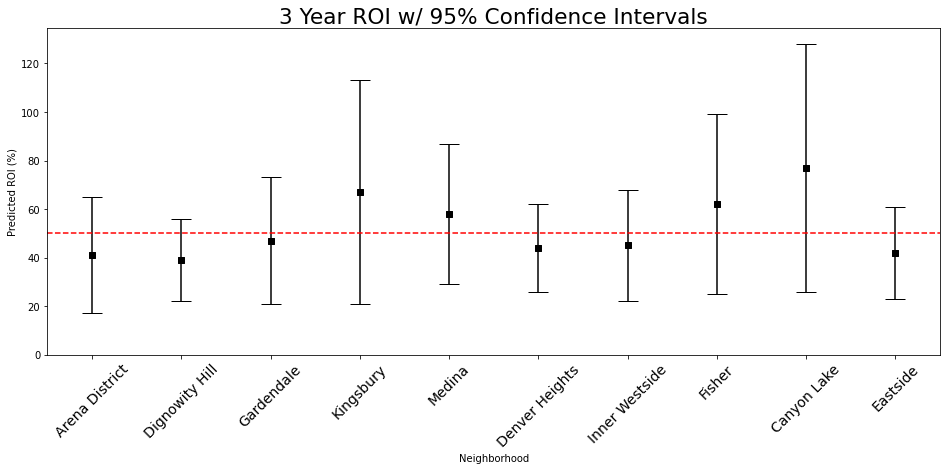

In [82]:
# 3 year ROI projections
projection_barplot(three_year_projections, years=3)

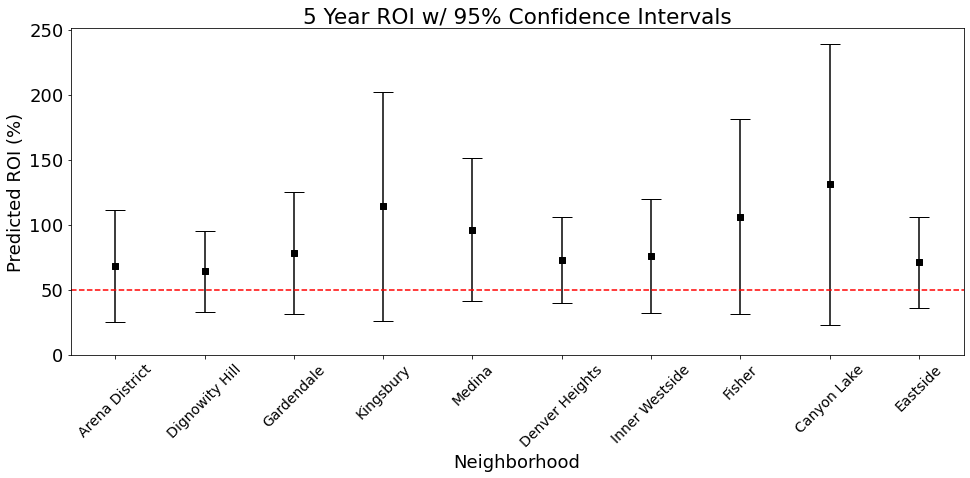

In [83]:
# 5 year ROI projections
projection_barplot(five_year_projections, years=5)

Since my client very concerned with low risk investments, I am going to select the top 5 zip codes from this list with the smallest confidence intervals.  This will remove those zip codes that have large variability and more fluctuation in the market vales.  These zip codes also happen to be the ones with the lowest ROI, but it appears it is hard to go wrong with any zip code in this metro area right now with it's massive growth with no end in sight.  

### Top 5 Zip Codes

In [84]:
# Top 5 zip codes
top_zip_projections = three_year_projections.sort_values('Predicted ROI (%)')[0:5].sort_values('Predicted ROI (%)',
                                                                                               ascending=False)
top_zip_projections

Neighborhood  Zip Code  Investment Value ($)  Predicted Sale Price ($)  \
6  Inner Westside     78237              163415.0                 237227.36   
5  Denver Heights     78210              234712.0                 337287.14   
9        Eastside     78220              183720.0                 260936.10   
0  Arena District     78203              241568.0                 339839.66   
1  Dignowity Hill     78202              228219.0                 316210.20   

   Min Pred Sale Price ($)  Max Pred Sale Price ($)  Predicted ROI (%)  \
6                199425.67                275029.05               45.0   
5                295798.77                378775.51               44.0   
9                226854.29                295017.91               42.0   
0                283808.21                395871.11               41.0   
1                277737.86                354682.55               39.0   

   Min Pred ROI (%)  Max Pred ROI (%)  errors  
6              22.0              68.0    23.0  
5              26.0              61.0    18.0  
9              23.0              61.0    19.0  
0              17.0              64.0    24.0  
1              22.0              55.0    17.0

Our top 5 zip codes are 78237 - Inner Westside, 78210 - Denver Heights, 78220 - Eastside, 78203 - Arena District, and 78202 - Dignowity Hill.  All 5 of these zip codes boast projected returns of 39% to 45%, and have great entry point prices ranging form 163k to 241k, far lower than the median value of the city.

78237 - Inner Westside, has the highest projected 3 year ROI and the lowest entry point at 163k, while 78202 - Dignowity Hill has the smallest variation and is therefore the safest investment, but also has a lower projected ROI.

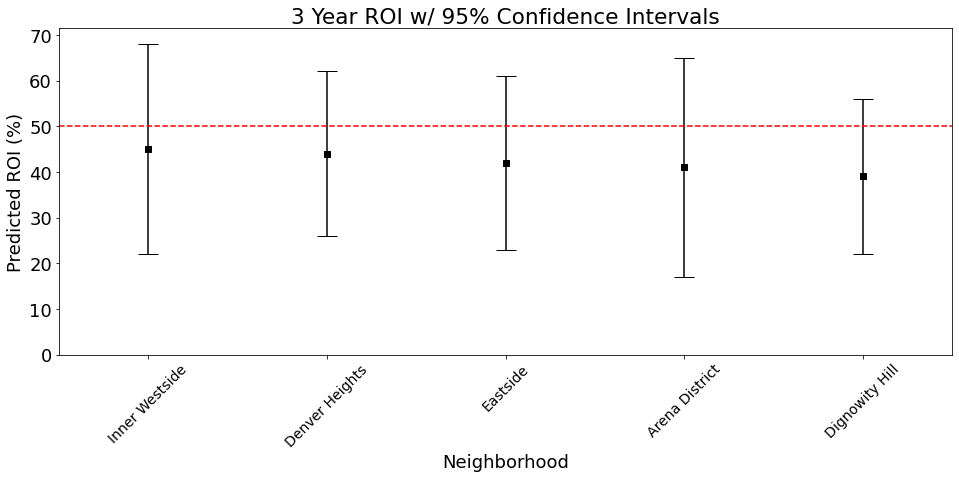

In [85]:
# Barplot of our 3 year projected ROI for top zip codes
projection_barplot(top_zip_projections, years=3, save_fig=True)

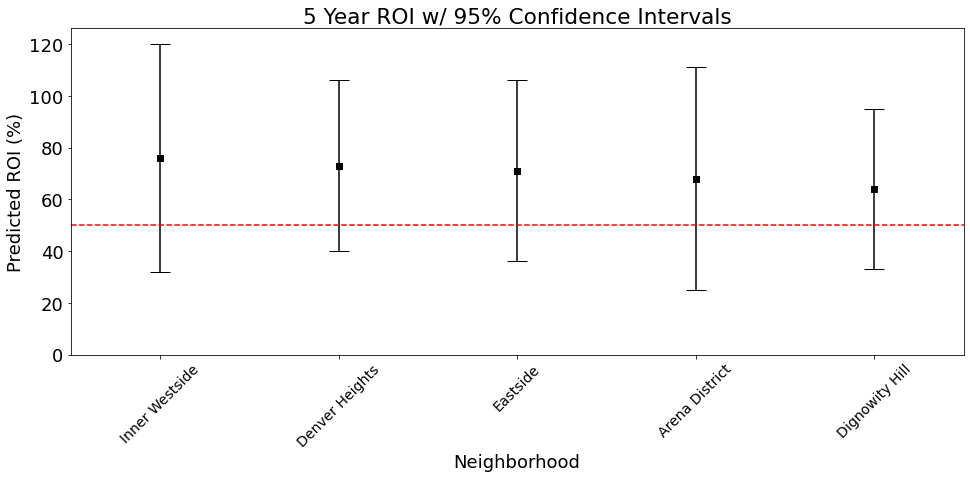

In [86]:
# Barplot of our 5 year projected ROI for our top zip codes
top_5year_projections = five_year_projections.sort_values('Predicted ROI (%)')[0:5].sort_values('Predicted ROI (%)',
                                                                                                ascending=False)
# Plot 5 year projections barplot
projection_barplot(top_5year_projections, years=5, save_fig=True)

Our top zip codes have projected 5 year ROI of 64% to 76%! Now lets visualize the average sale prices or our top 5 zip codes over 22 years.

### Average Housing Prices of our Top 5 Zip Codes from 2000 - 2022

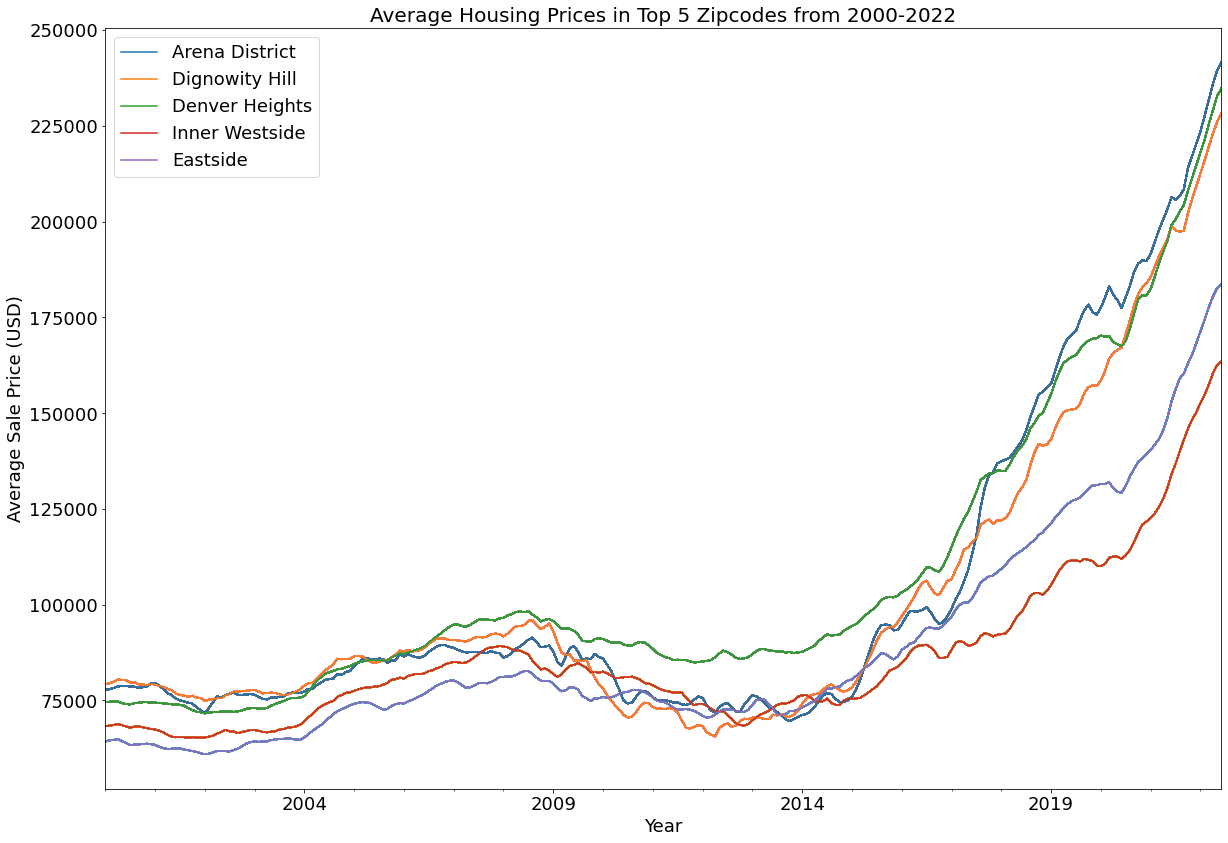

In [87]:
# Top 5 zip codes
top_5_zipcodes = [78203,78202,78210,78237,78220]

#plot the values grouped by zip code
plt.figure(figsize=(20,14))
for zipcode in model_df.RegionName.unique():
    for zipcode in top_5_zipcodes:
        model_df.loc[model_df['RegionName'] == zipcode].value.plot(label=zipcode)

plt.legend(labels=('Arena District','Dignowity Hill','Denver Heights',
                   'Inner Westside','Eastside'), loc='upper left')

plt.xlabel("Year", fontsize = 18)
plt.ylabel("Average Sale Price (USD)", fontsize=18)
plt.title('Average Housing Prices in Top 5 Zipcodes from 2000-2022', fontsize = 20)
# Save fig
plt.savefig('./images/top_5_over_time.jpeg')
plt.show();

We can see a similiar trend among all of our top 5 zip codes, although a bit more pronounced in the Arena District, Dignowity Hill, and Denver Heights.  This is likely due to the gentrification that has been taking place in these neighborhoods over the past several years and becoming desirable hotspots.  Unfortunately,  the crime rate is high in all of these neighborhoods and the schools all have below average ratings. It will likely take the schools several years to improve with the transition. 

### Map Visualization of Top 5 Zip Codes

In [88]:
#Import
import folium

#Create map
this_map = folium.Map(location = [29.5, -98.5])

# Add markers for zip codes 
folium.Marker(location=[29.4151, -98.4605], tooltip = 'Arena District').add_to(this_map)
folium.Marker(location=[29.4278, -98.4615], tooltip = 'Dignowity Hill').add_to(this_map)
folium.Marker(location=[29.3958, -98.4638], tooltip = 'Denver Heights').add_to(this_map)
folium.Marker(location=[29.4204, -98.5671], tooltip = 'Inner Westside').add_to(this_map)
folium.Marker(location=[29.4139, -98.3889], tooltip = 'Eastside').add_to(this_map)
 
#Set the zoom to fit our bounds
this_map.fit_bounds(this_map.get_bounds())

this_map

In [89]:
top_zip_projections

Neighborhood  Zip Code  Investment Value ($)  Predicted Sale Price ($)  \
6  Inner Westside     78237              163415.0                 237227.36   
5  Denver Heights     78210              234712.0                 337287.14   
9        Eastside     78220              183720.0                 260936.10   
0  Arena District     78203              241568.0                 339839.66   
1  Dignowity Hill     78202              228219.0                 316210.20   

   Min Pred Sale Price ($)  Max Pred Sale Price ($)  Predicted ROI (%)  \
6                199425.67                275029.05               45.0   
5                295798.77                378775.51               44.0   
9                226854.29                295017.91               42.0   
0                283808.21                395871.11               41.0   
1                277737.86                354682.55               39.0   

   Min Pred ROI (%)  Max Pred ROI (%)  errors  
6              22.0              68.0    23.0  
5              26.0              61.0    18.0  
9              23.0              61.0    19.0  
0              17.0              64.0    24.0  
1              22.0              55.0    17.0

## Recommendations

The top 5 zip codes ranked by highest return on investment (ROI) with the least amount of unpredictability and variation are:
* 78237: Inner Westside
* 78210: Denver Heights
* 78220: Eastside
* 78203: Arena District
* 78202: Dignowity Hill

These 5 zip codes boast projected returns on a 3 year investment ranging from 38% to 45%, and 5 year returns from 64% to 75%!  The entry price into these neighborhoods range from 163k to 241k, much lower than the average median price of the whole SA metro area at 348k.  Following are details and my recommendations for purchasing in each of these areas.

### Inner Westside

The Inner Westside has the lowest initial investment value at 163k and the highest projected 3 and 5 year ROI at 45% and 76%, respectively. Homes should be bought in the winter and sold in the summer for an additional 2% ROI.

### Denver Heights

Denver Heights has an initial investment value of 235k, which is the 2nd highest in our recommended zip codes.  It has a projected 3 year ROI of 44% and 5 year ROI at 73%. It has become a millennial hot spot with a median age of 27 due to its close proximity to downtown and is already in the process of becoming an up and coming neighborhood.  It has low variation in the median sale price month over month which makes one of our safest investments.

### Eastside

The Eastside has an initial investment value of 184k, making it the 2nd lowest on our list.  It has a 3 year projected ROI of 42%, while its 5 year projected ROI is 71%.  It also has low variation in the data making it a safe investment.  This area offers opportunities to purchase larger plots of land, as this area was mostly used for agricultural purposes up until recently, as the demand has increased from people wanting more land and privacy.

### Arena District

The Arena District surrounds the AT&T Center where the Spurs play, and is loaded with bars, coffee shops, restaurants, and parks.  This has been another rising millennial hot spot over the last several years. It is projected to have a 3 and 5 year ROI of 41% and 68%, respectively.  The initial investment will cost 242k, which is the highest of our recommended zip codes.  It also has largest errors in its predictions, making it our riskiest investment, relatively speaking.  Interestingly enough, homes should be purchased in the winter and sold in the summer which does not follow the normal trends that we typically see.  This strategy will add an additional 2% ROI when buying and selling in the Arena District.  

### Dignowity Hill

Dignowity Hill was the first residential suburb in San Antonio and is now a historic zone.  The area now offers parks, restaurants, historic buildings, and renovated high end estates making it a place for everyone.  It has an initial investment value of 228k, and projected 3 and 5 year ROI of 39% and 64%, respectively.  Homes should be purchased in the winter and sold in the summer for an additional gain of 1% ROI.  There is the smallest error in our predictions for this zip code, making this our safest investment.

As stated before, all of the home prices in these areas are significantly lower than the median home price of the San Antonio area. It should be noted that there is a caveat to these low prices, the schools are below average in every one of these zip codes and the rate of crime is high.  This is typical in big cities, and the schools typically improve as time goes on in neighborhoods with increasing home value.  If any of these factors are a concern, I recommend taking a look at the other zip codes that were in our top 10 ROI.  These other zip codes are in more desirable suburban areas that have good schools, but also come at a much higher entry point and more risk associated with the purchase. 

## Future Work

Our model only looked at factors endogenous to the time series data.  While this is useful for understanding how real estate markets change over time, it does nothing to explain all the other factors that are driving changes in housing prices. Some next steps in this project include added exogenous factors to our model:
* Interest rates
* Crime data
* Median income over time

I would also like to explore other areas in the dataset and modeling packages such as Facebook Prophet.